In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Shared imports for this notebook (method-specific imports stay near their cells).



In [276]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Helper: summarize clustering results with context (cluster counts + metrics)
def summarize_clusters(labels, X=None, method_name="Clustering", noise_label=None):
    labels = np.asarray(labels)
    total = len(labels)

    # Identify noise points (if applicable)
    if noise_label is None:
        noise_mask = np.zeros_like(labels, dtype=bool)
    else:
        noise_mask = labels == noise_label

    n_noise = int(noise_mask.sum())
    used_mask = ~noise_mask
    unique_labels = np.unique(labels[used_mask]) if used_mask.any() else []

    # Cluster sizes (excluding noise)
    if used_mask.any():
        cluster_ids, counts = np.unique(labels[used_mask], return_counts=True)
        size_map = dict(zip(cluster_ids.tolist(), counts.tolist()))
    else:
        size_map = {}

    print(f"\n[{method_name}]")
    print(f"Total points: {total}")
    if noise_label is not None:
        print(f"Noise points: {n_noise} ({n_noise / total:.2%})")
    print(f"Number of clusters (excluding noise): {len(unique_labels)}")
    print(f"Cluster sizes (excluding noise): {size_map}")

    # Metrics: compute on non-noise points when noise exists
    if X is not None and len(unique_labels) >= 2:
        X_eval = X[used_mask] if noise_label is not None else X
        labels_eval = labels[used_mask] if noise_label is not None else labels

        silhouette = silhouette_score(X_eval, labels_eval)
        davies_bouldin = davies_bouldin_score(X_eval, labels_eval)
        calinski_harabasz = calinski_harabasz_score(X_eval, labels_eval)

        print(f"Silhouette Score: {silhouette}")
        print(f"Davies-Bouldin Index: {davies_bouldin}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    else:
        print("Metrics not computed (need at least 2 non-noise clusters).")


# Helper: pick best KMeans k by silhouette
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

def select_best_kmeans(X, k_range, random_state=42):
    best = {"score": -1, "k": None}
    for k in k_range:
        labels = KMeans(n_clusters=k, random_state=random_state).fit_predict(X)
        if len(np.unique(labels)) < 2:
            continue
        score = silhouette_score(X, labels)
        if score > best["score"]:
            best.update({"score": score, "k": k})
    return best


# Helper: pick best agglomerative k by silhouette

def select_best_agglomerative(X, k_range, linkages=("ward",)):
    if isinstance(linkages, str):
        linkages = (linkages,)
    best = {"score": -1, "k": None, "linkage": None}
    for linkage in linkages:
        for k in k_range:
            labels = AgglomerativeClustering(n_clusters=k, linkage=linkage).fit_predict(X)
            if len(np.unique(labels)) < 2:
                continue
            score = silhouette_score(X, labels)
            if score > best["score"]:
                best.update({"score": score, "k": k, "linkage": linkage})
    return best


# Helper: pick best DBSCAN params under a noise cap

def select_best_dbscan(X, eps_values, min_samples_values, noise_cap=0.30):
    best = {"score": -1, "eps": None, "min_samples": None, "noise_pct": None}
    for eps in eps_values:
        for min_samples in min_samples_values:
            labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
            noise_mask = labels == -1
            noise_pct = noise_mask.mean()
            if noise_pct > noise_cap:
                continue
            if noise_mask.all():
                continue
            X_non_noise = X[~noise_mask]
            labels_non_noise = labels[~noise_mask]
            if len(np.unique(labels_non_noise)) < 2:
                continue
            score = silhouette_score(X_non_noise, labels_non_noise)
            if score > best["score"]:
                best.update({
                    "score": score,
                    "eps": eps,
                    "min_samples": min_samples,
                    "noise_pct": noise_pct,
                })
    return best


# Helper: reusable Georgia county map colored by cluster assignment.
# Works for any number of clusters and optionally highlights noise (e.g. DBSCAN).

def plot_ga_cluster_map(cluster_labels, county_names, title="Cluster Map of Georgia Counties",
                        shapefile_path='./Counties_Georgia/Counties_Georgia.shp',
                        noise_label=None):
    """Plot a Georgia county map color-coded by cluster assignment.

    Parameters
    ----------
    cluster_labels : array-like   – cluster id per data point
    county_names   : array-like   – county name per data point (same order)
    title          : str          – plot title
    shapefile_path : str          – path to Georgia shapefile
    noise_label    : int or None  – label treated as noise (e.g. -1 for DBSCAN)
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import pandas as pd
    import numpy as np

    geo_data = gpd.read_file(shapefile_path)
    cluster_df = pd.DataFrame({'County': county_names, 'Cluster': cluster_labels})
    geo_merged = geo_data.merge(cluster_df, how='left', left_on='NAME10', right_on='County')

    # Determine unique non-noise clusters
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c != noise_label])
    n_clusters = len(unique_clusters)

    # Auto-generate distinct colors via viridis
    cmap_colors = plt.cm.viridis(np.linspace(0, 0.9, max(n_clusters, 1)))
    color_map = {cluster: cmap_colors[i] for i, cluster in enumerate(unique_clusters)}
    if noise_label is not None:
        color_map[noise_label] = np.array([0.86, 0.77, 0.94, 1.0])  # light purple for noise

    not_in_dataset_color = '#CCC0F1'

    geo_merged['color'] = geo_merged['Cluster'].apply(
        lambda x: color_map.get(x, not_in_dataset_color)
    )

    # Build legend automatically
    legend_elements = []
    for cluster in unique_clusters:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w',
                   label=f'Cluster {cluster}',
                   markerfacecolor=color_map[cluster], markersize=10)
        )
    if noise_label is not None:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label='Noise',
                   markerfacecolor=color_map[noise_label], markersize=10)
        )
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label='Not in Dataset',
               markerfacecolor=not_in_dataset_color, markersize=10)
    )

    fig, ax = plt.subplots(1, figsize=(12, 12))
    geo_merged.plot(color=geo_merged['color'], ax=ax, edgecolor='black', linewidth=1)
    ax.set_title(title)
    ax.axis('off')
    ax.legend(handles=legend_elements, loc='lower left')
    plt.tight_layout()
    plt.show()



In [277]:
fifty_coefficients_df = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv')
coefficients_df = pd.read_csv('./pivoted_model_coefficients_for_all_features.csv')


coefficients_df_cleaned = coefficients_df.dropna() 
originalDFSet = coefficients_df['County'].unique()
cleanedDF = coefficients_df_cleaned['County'].unique()

fifty_ds_cleaned = fifty_coefficients_df.dropna()
fifty_coefficients_df = fifty_coefficients_df['County'].unique()
fifty_ds_cleaned = fifty_ds_cleaned['County'].unique()

print(set(originalDFSet) - set(cleanedDF))
print(set(fifty_coefficients_df) - set(fifty_ds_cleaned))



{'Bacon', 'Jeff Davis', 'Taliaferro', 'Montgomery', 'Ben Hill', 'Jenkins'}
{'Quitman', 'Bacon', 'Appling', 'Sumter', 'Clay', 'Bulloch', 'Upson', 'Jenkins', 'Dodge', 'Telfair', 'McIntosh', 'Baker', 'Lamar', 'Mitchell', 'Morgan', 'Pike', 'Atkinson', 'Ben Hill', 'Stewart', 'Towns', 'Greene', 'Montgomery', 'Dawson', 'Jeff Davis', 'Jasper', 'Lee', 'Stephens', 'Cook', 'Chattooga', 'Laurens', 'Glascock', 'Franklin', 'Heard', 'Taliaferro', 'Monroe', 'Long', 'Chattahoochee', 'Jones', 'Putnam', 'Calhoun', 'Union', 'Webster'}


First Step: Visualizations and Principal Component Analysis 

Using PCA components: 5


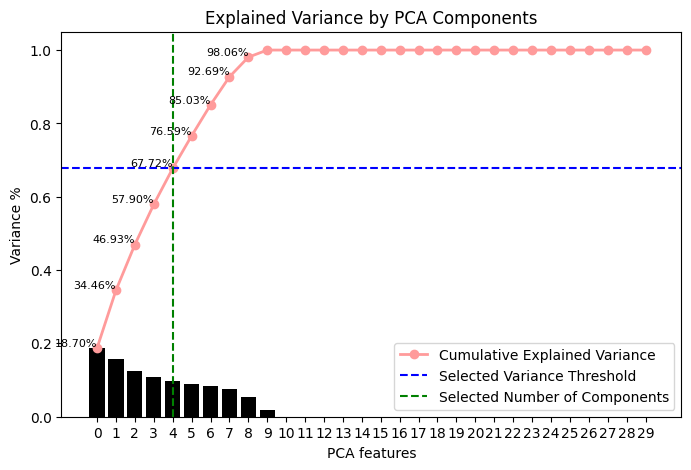

Selected components explain 67.72% variance: 5 components


In [278]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values

# Use a fixed PCA component count for consistency with prior runs
PCA_COMPONENTS = 5
print(f"Using PCA components: {PCA_COMPONENTS}")

# Fit PCA and plot the individual explained variance
pca = PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.figure(figsize=(8, 5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title('Explained Variance by PCA Components')

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance trend line
plt.plot(features, cumulative_variance, color='#FF9B9B', marker='o', linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Annotate the points for the first 9 features or until cumulative variance reaches 100%
for i, v in enumerate(cumulative_variance):
    if v < 1.0 and i < 9:  # Check if the cumulative variance is less than 100% and within the first 9 features
        plt.text(i, v, f"{v:.2%}", fontsize=8, ha='right', va='bottom')

# Use the selected PCA component count to determine its explained variance
components_for_threshold = PCA_COMPONENTS
variance_threshold = cumulative_variance[components_for_threshold - 1]

# Add a horizontal line at the selected variance threshold
plt.axhline(y=variance_threshold, color='blue', linestyle='--', label='Selected Variance Threshold')

# Add a vertical line at the selected component count
plt.axvline(x=components_for_threshold - 1, color='green', linestyle='--', label='Selected Number of Components')

# Show the plot with legends
plt.legend()
plt.show()

# Print the variance explained by the selected number of components
print(f"Selected components explain {variance_threshold*100:.2f}% variance: {components_for_threshold} components")


In [279]:
import pandas as pd
from sklearn.decomposition import PCA

# Let's say 'X' is your dataset and 'features' is the list of column names
pca = PCA(n_components=PCA_COMPONENTS)
pca.fit(X)

# Create a DataFrame with the loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PCA Component #{i+1}' for i in range(PCA_COMPONENTS)],
    index=features,
)

# Function to map each feature to its most contributing PCA component
def map_features_to_components(loadings_df):
    feature_component_map = {}
    for feature in loadings_df.index:
        dominant_component = loadings_df.loc[feature].abs().idxmax()
        if dominant_component in feature_component_map:
            feature_component_map[dominant_component].append(feature)
        else:
            feature_component_map[dominant_component] = [feature]
    return feature_component_map

# Map the features to components
features_mapped_to_components = map_features_to_components(loadings)

# Print the mapping
for component, features_list in features_mapped_to_components.items():
    # Ensure features are printed as strings for readability
    feature_names = [str(feature) for feature in features_list]
    print(f"{component} key features: {', '.join(feature_names)}")


PCA Component #2 key features: 0, 1, 2, 6, 7, 8, 12, 13, 14
PCA Component #5 key features: 3, 4, 5, 27, 28, 29
PCA Component #3 key features: 9, 10, 11, 24, 25, 26
PCA Component #1 key features: 15, 16, 17, 18, 19, 20
PCA Component #4 key features: 21, 22, 23


Using UMAP components: 5


/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/1324974801.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette="viridis", legend='full')


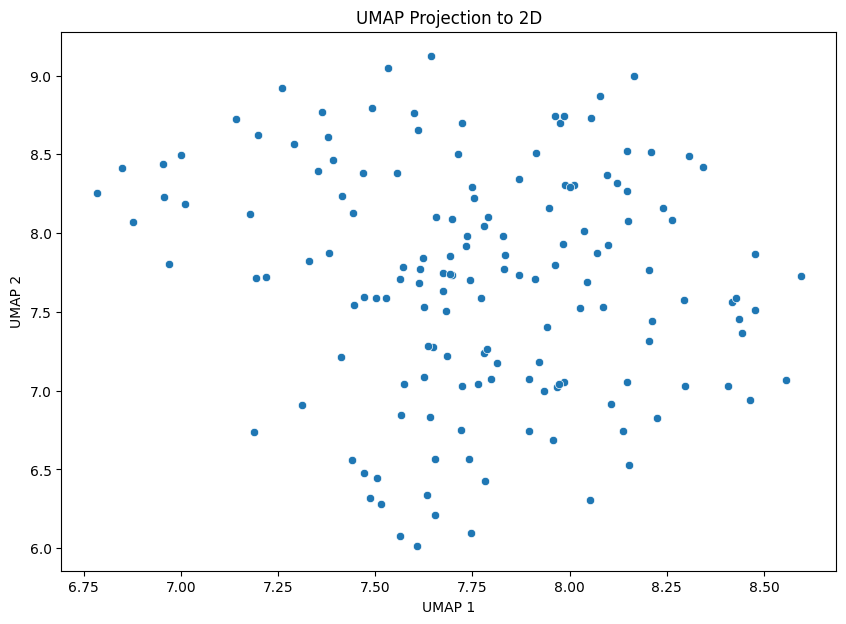

/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/1324974801.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap='viridis', edgecolor='k')


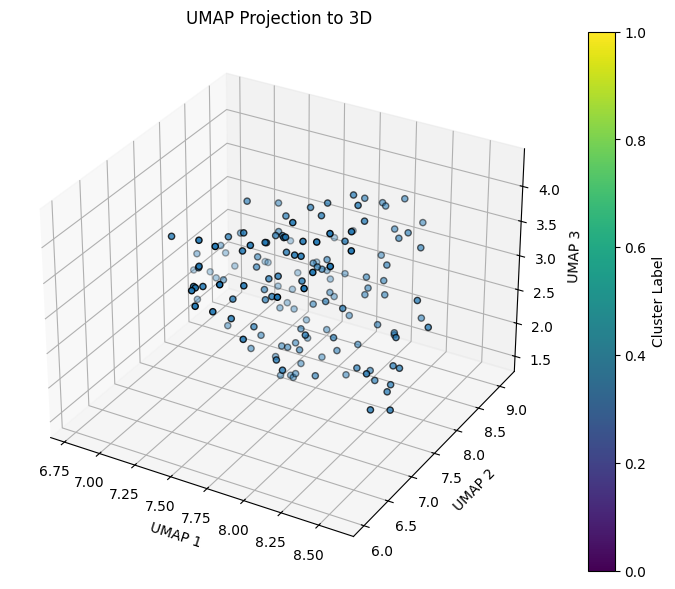

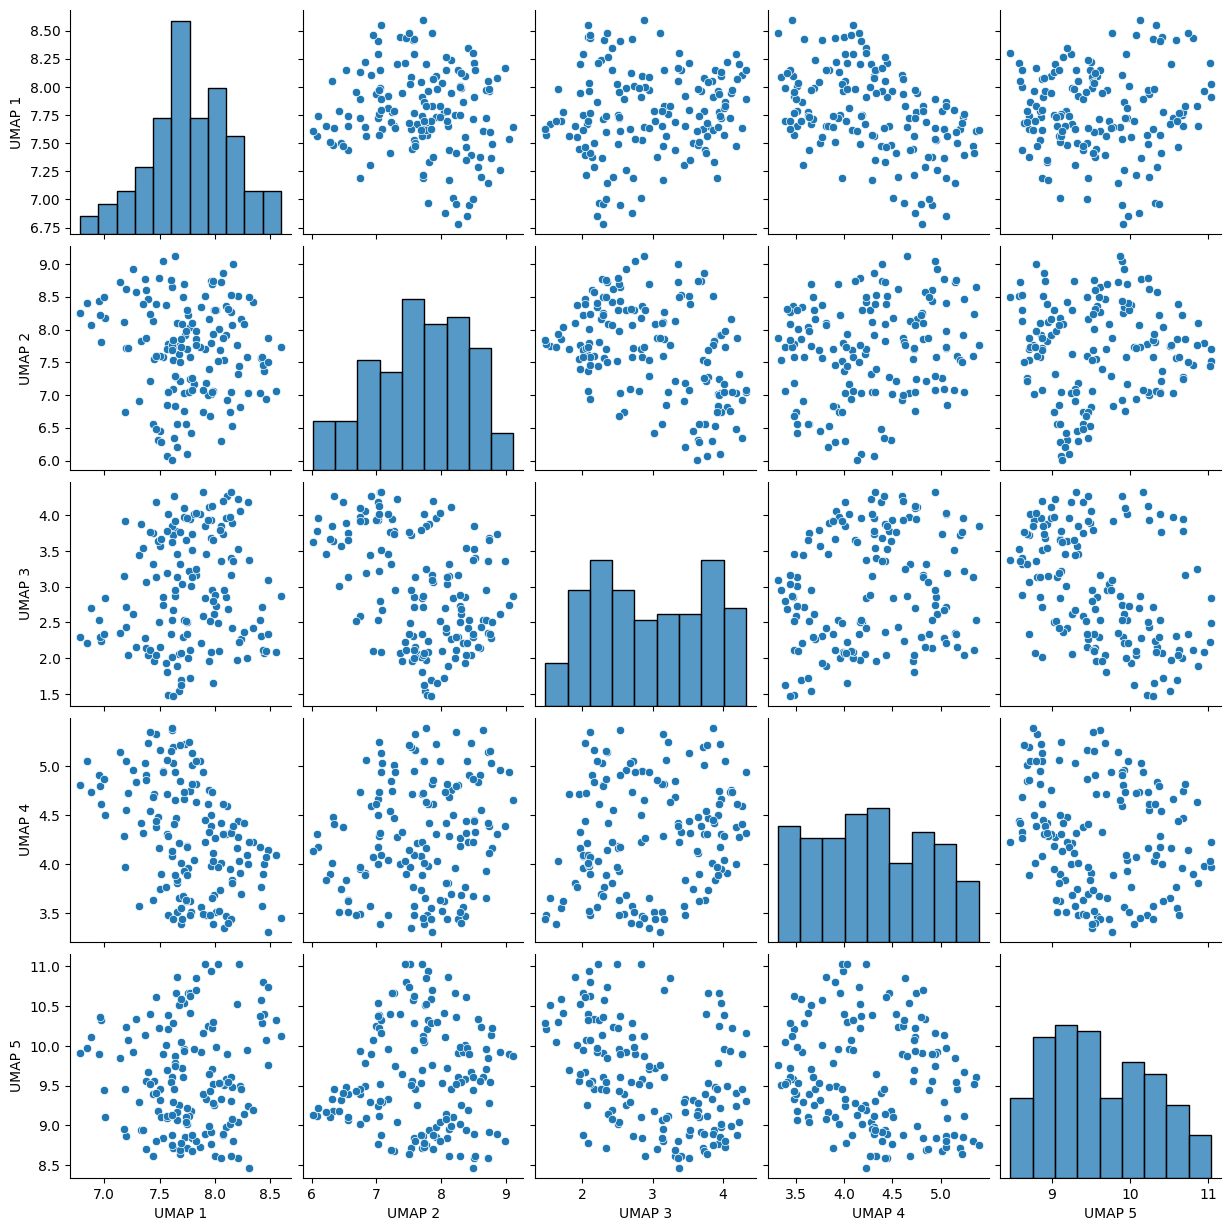

In [280]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

features_to_scale = coefficients_df_cleaned.columns.drop('County')

# Assuming 'X' is your dataset
X = coefficients_df_cleaned[features_to_scale].values

# Use fixed UMAP components for consistency with prior runs
UMAP_COMPONENTS = 5
print(f"Using UMAP components: {UMAP_COMPONENTS}")

reducer = umap.UMAP(n_components=UMAP_COMPONENTS, random_state=42)
X_umap = reducer.fit_transform(X)

# For visualization, we can only plot in 2D or 3D directly.
# Let's plot the first 2 components as an example.
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette="viridis", legend='full')
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# And a 3D plot for the first three components (only if we have >= 3)
if UMAP_COMPONENTS >= 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap='viridis', edgecolor='k')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('UMAP Projection to 3D')
    plt.show()
else:
    print("Skipping 3D plot: UMAP returned fewer than 3 components.")


# Create a DataFrame from the UMAP output for easier plotting
umap_df = pd.DataFrame(X_umap, columns=[f'UMAP {i+1}' for i in range(UMAP_COMPONENTS)])

# Use seaborn's pairplot to visualize the distribution and relationship of components
sns.pairplot(umap_df)
plt.show()


Second Step: Clustering 

Determined the optimal number of clusters using nbclust package: R, elbow method, sillhouette scores graph 

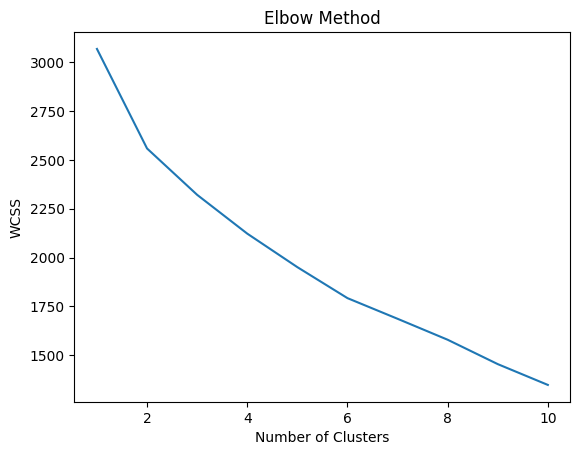

In [281]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

coefficients_df_cleaned = coefficients_df.dropna() 

features_to_scale = coefficients_df_cleaned.columns.drop('County')
#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)

wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")
plt.show() 

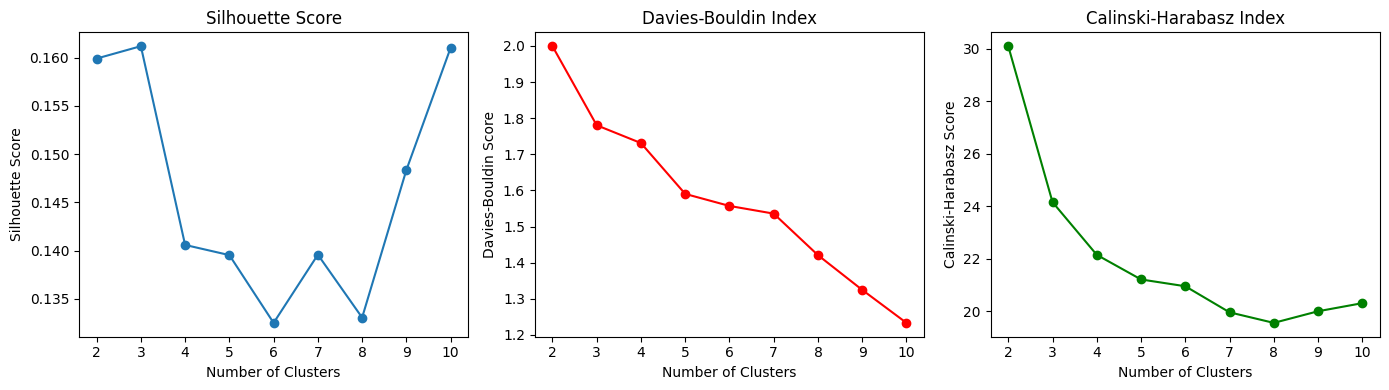

In [282]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)
X = X_pca

# Prepare lists to store the scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Range of cluster numbers to try
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Compute the metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    davies_bouldin = davies_bouldin_score(X, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

    # Store the scores
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

# Plot the Silhouette Score
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel('Number of Clusters')
plt.ylabel("Silhouette Score")

# Plot the Davies-Bouldin Index (remember, for this metric, lower is better)
plt.subplot(132)
plt.plot(n_clusters_range, davies_bouldin_scores, marker='o', color='r')
plt.title("Davies-Bouldin Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Davies-Bouldin Score")

# Plot the Calinski-Harabasz Index
plt.subplot(133)
plt.plot(n_clusters_range, calinski_harabasz_scores, marker='o', color='g')
plt.title("Calinski-Harabasz Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Calinski-Harabasz Score")

plt.tight_layout()
plt.show()


Best KMeans k: 3  (silhouette=0.1612)
Silhouette Score: 0.1612073892879878
Davies-Bouldin Index: 1.7803811973078896
Calinski-Harabasz Index: 24.15581740671971

[KMeans (PCA 5D, k=3)]
Total points: 153
Number of clusters (excluding noise): 3
Cluster sizes (excluding noise): {0: 69, 1: 69, 2: 15}
Silhouette Score: 0.1612073892879878
Davies-Bouldin Index: 1.7803811973078896
Calinski-Harabasz Index: 24.15581740671971


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/2211486456.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


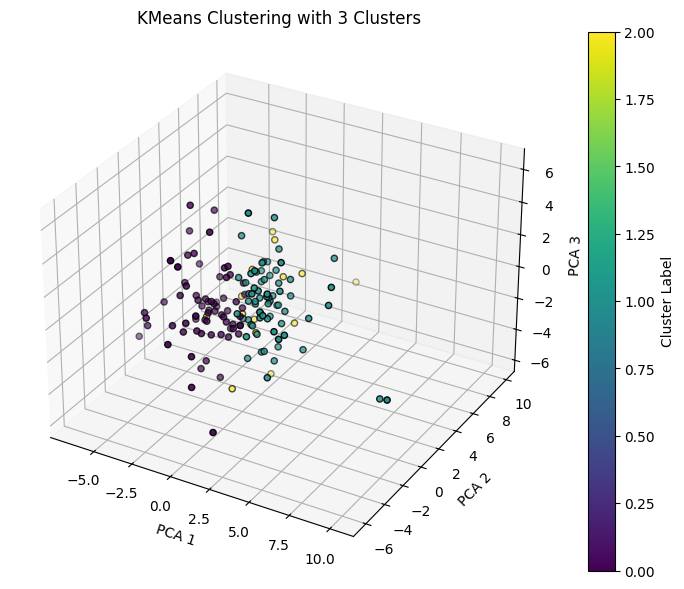

     cluster
0          0
1          1
2          2
3          0
4          1
..       ...
148        1
149        1
150        1
151        0
152        0

[153 rows x 1 columns]
cluster
0    69
1    69
2    15
dtype: int64


In [283]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

# Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)

# Grid-search k by silhouette score.
# This is fast (just tries 9 values) and safe — always produces k clusters.
k_search = select_best_kmeans(X_pca, k_range=range(2, 11))
kmeans_k = k_search["k"]
print(f"Best KMeans k: {kmeans_k}  (silhouette={k_search['score']:.4f})")

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=kmeans_k, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Add cluster-size context for interpretation
summarize_clusters(cluster_labels, X_pca, method_name=f"KMeans (PCA {PCA_COMPONENTS}D, k={kmeans_k})")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'KMeans Clustering with {kmeans_k} Clusters')

plt.show()

# Create a new dataframe with the cluster labels
df_clusters = pd.DataFrame({'cluster': cluster_labels})

# Print the new dataframe
print(df_clusters)

# Print cluster counts
print(df_clusters.groupby('cluster').size())


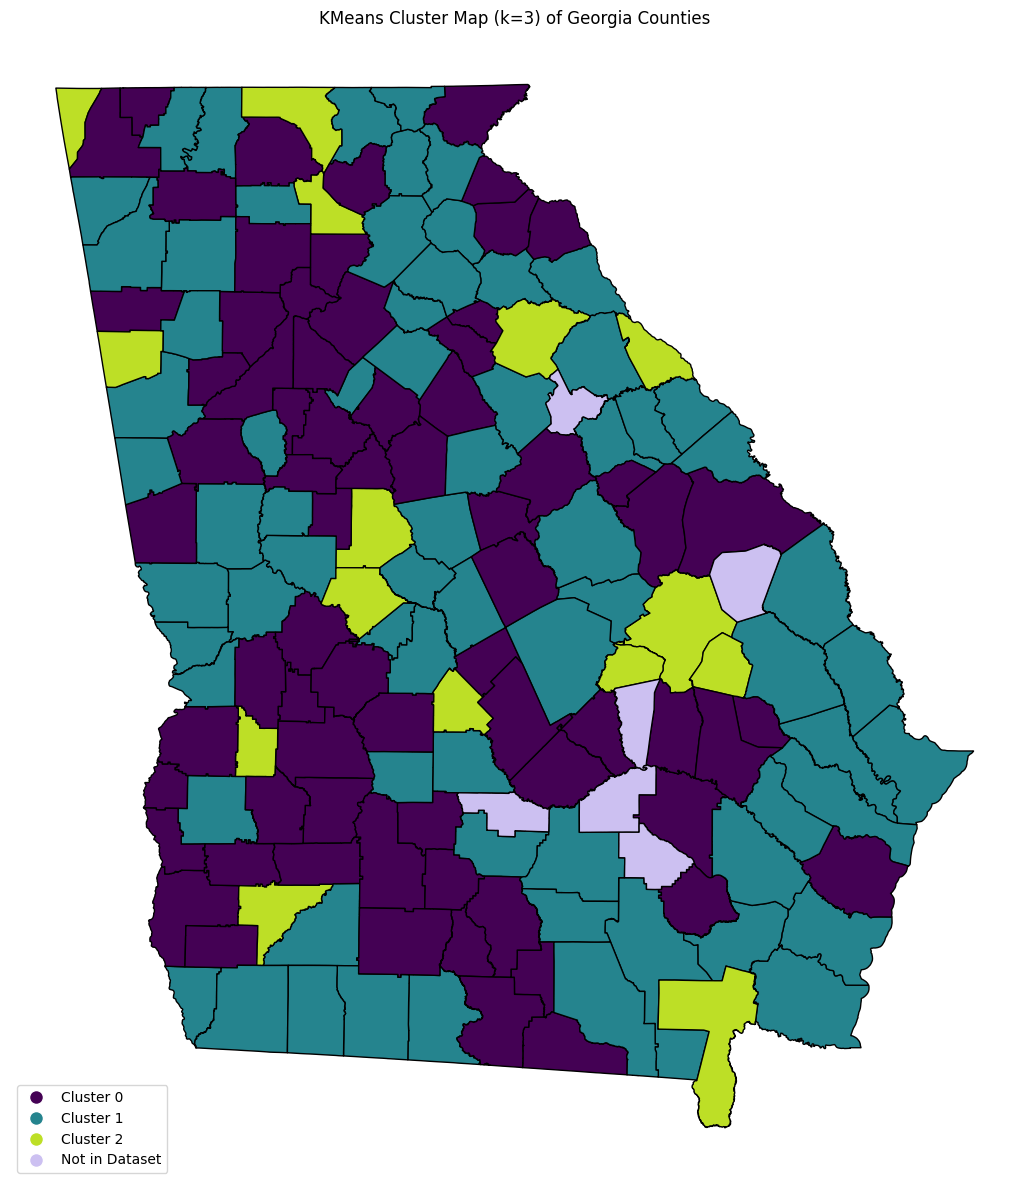

In [284]:
# Georgia map for KMeans clusters — uses the reusable helper so it works for any k
plot_ga_cluster_map(
    cluster_labels,
    coefficients_df_cleaned['County'].values,
    title=f'KMeans Cluster Map (k={kmeans_k}) of Georgia Counties',
)


In [285]:
import numpy as np

# Assuming X_pca is your PCA-reduced dataset
X = X_pca

# Define search ranges and noise cap
EPS_VALUES = np.arange(1, 10, 0.1)
MIN_SAMPLES_VALUES = range(2, 25)  # 2 * numDimensions
NOISE_CAP = 0.30

best_dbscan = select_best_dbscan(
    X,
    eps_values=EPS_VALUES,
    min_samples_values=MIN_SAMPLES_VALUES,
    noise_cap=NOISE_CAP,
)

print("DBSCAN best params under noise cap:")
print(
    f"Best Score: {best_dbscan['score']}, eps: {best_dbscan['eps']}, "
    f"min_samples: {best_dbscan['min_samples']}, noise_pct: {best_dbscan['noise_pct']:.2%}"
)

DBSCAN best params under noise cap:
Best Score: 0.4837441303204811, eps: 5.5000000000000036, min_samples: 2, noise_pct: 1.31%



[DBSCAN (PCA 5D)]
Total points: 153
Noise points: 2 (1.31%)
Number of clusters (excluding noise): 2
Cluster sizes (excluding noise): {0: 149, 1: 2}
Silhouette Score: 0.4837441303204811
Davies-Bouldin Index: 0.6560648440720702
Calinski-Harabasz Index: 11.131356570165961


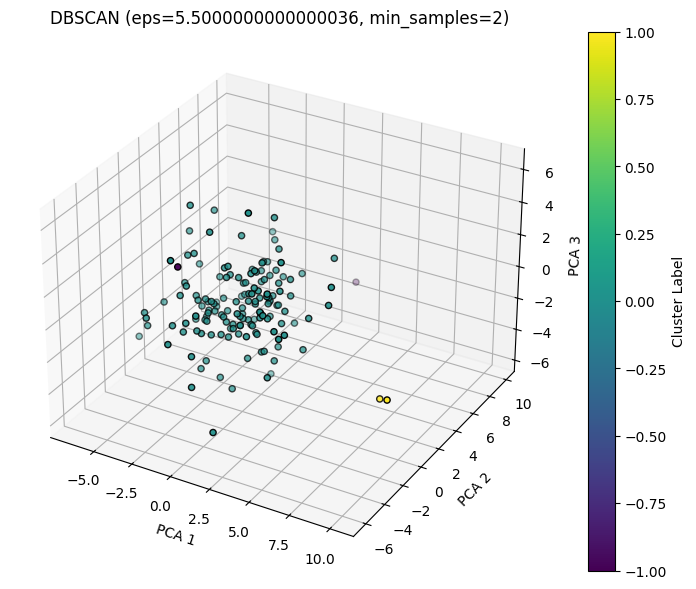

[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [286]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN



# Assuming 'X' is your dataset
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)

# Run DBSCAN with best params from grid search
if best_dbscan["eps"] is None:
    raise ValueError("DBSCAN grid search found no valid params under noise cap.")

dbscan = DBSCAN(eps=best_dbscan["eps"], min_samples=best_dbscan["min_samples"])
clusters = dbscan.fit_predict(X_pca)

# Summary includes noise proportion (label -1) and metrics on non-noise points
summarize_clusters(clusters, X_pca, method_name=f"DBSCAN (PCA {PCA_COMPONENTS}D)", noise_label=-1)

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'DBSCAN (eps={best_dbscan["eps"]}, min_samples={best_dbscan["min_samples"]})')

plt.show()

print(clusters)

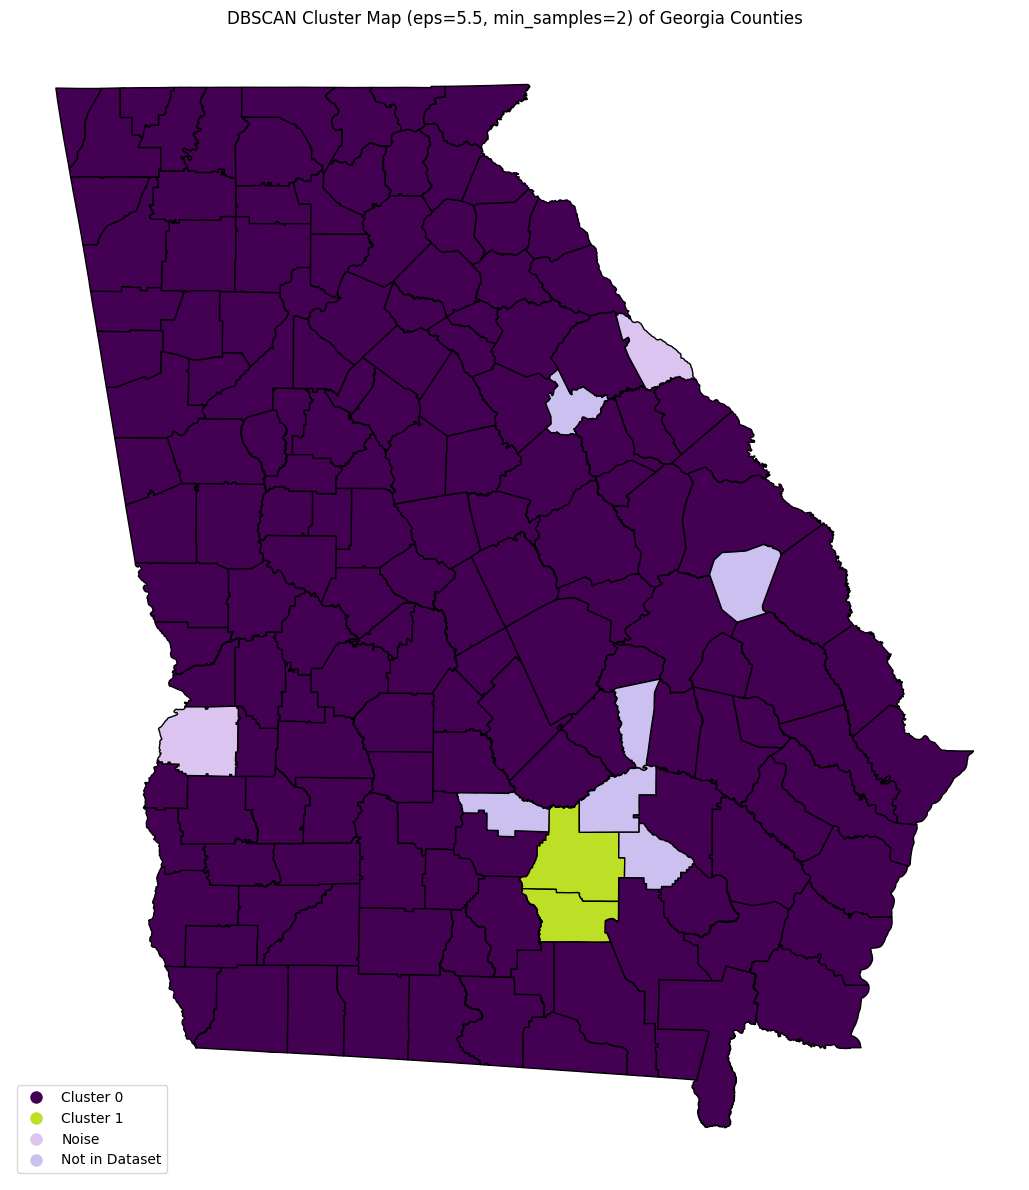

In [287]:
# Georgia map for DBSCAN clusters — handles noise label (-1) and any number of clusters
plot_ga_cluster_map(
    clusters,
    coefficients_df_cleaned['County'].values,
    title=f'DBSCAN Cluster Map (eps={best_dbscan["eps"]:.1f}, min_samples={best_dbscan["min_samples"]}) of Georgia Counties',
    noise_label=-1,
)

Hierarchical (Agglomerative) Clustering 

In [288]:
# (Grid search for Agglomerative k + linkage is now done directly in the next cell.)


Best Agglomerative: linkage=complete, k=2  (silhouette=0.4807)
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Silhouette Score: 0.4807459895084211
Davies-Bouldin Index: 1.2889904616067178
Calinski-Harabasz Index: 10.00634876281533

[Agglomerative (complete, k=2)]
Total points: 153
Number of clusters (excluding noise): 2
Cluster sizes (excluding noise): {0: 150, 1: 3}
Silhouette Score: 0.4807459895084211
Davies-Bouldin Index: 1.2889904616067178
Calinski-Harabasz Index: 10.00634876281533


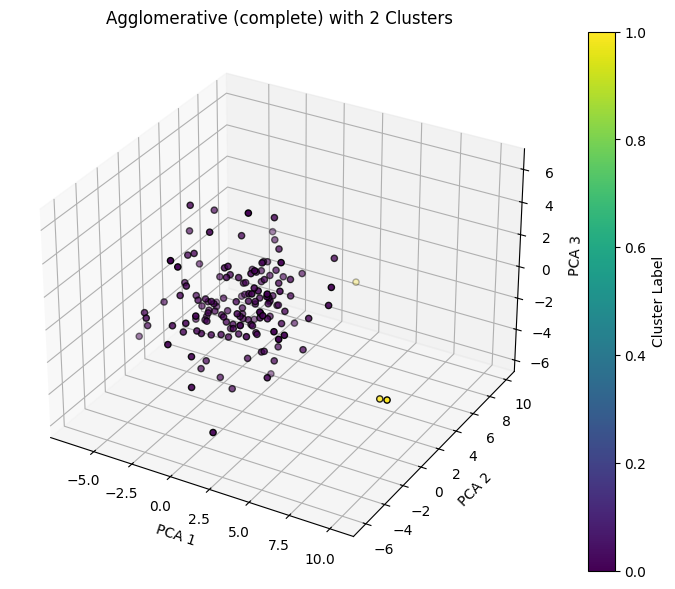

In [289]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_pca is your PCA-reduced dataset

# Grid-search k and linkage by silhouette.
# Fast (9 k-values × 4 linkages = 36 combos) and safe — always produces k clusters.
linkage_options = ["ward", "complete", "average", "single"]
agg_search = select_best_agglomerative(X_pca, k_range=range(2, 11), linkages=linkage_options)
agg_linkage = agg_search["linkage"]
agg_k = agg_search["k"]
print(f"Best Agglomerative: linkage={agg_linkage}, k={agg_k}  (silhouette={agg_search['score']:.4f})")

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=agg_linkage, n_clusters=agg_k, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 5: Extract cluster labels
cluster_labels_agg = agg_clustering.labels_
print(cluster_labels_agg)

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels_agg)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels_agg)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels_agg)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Add cluster-size context for interpretation
summarize_clusters(cluster_labels_agg, X_pca, method_name=f"Agglomerative ({agg_linkage}, k={agg_k})")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels_agg, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'Agglomerative ({agg_linkage}) with {agg_k} Clusters')

plt.show()


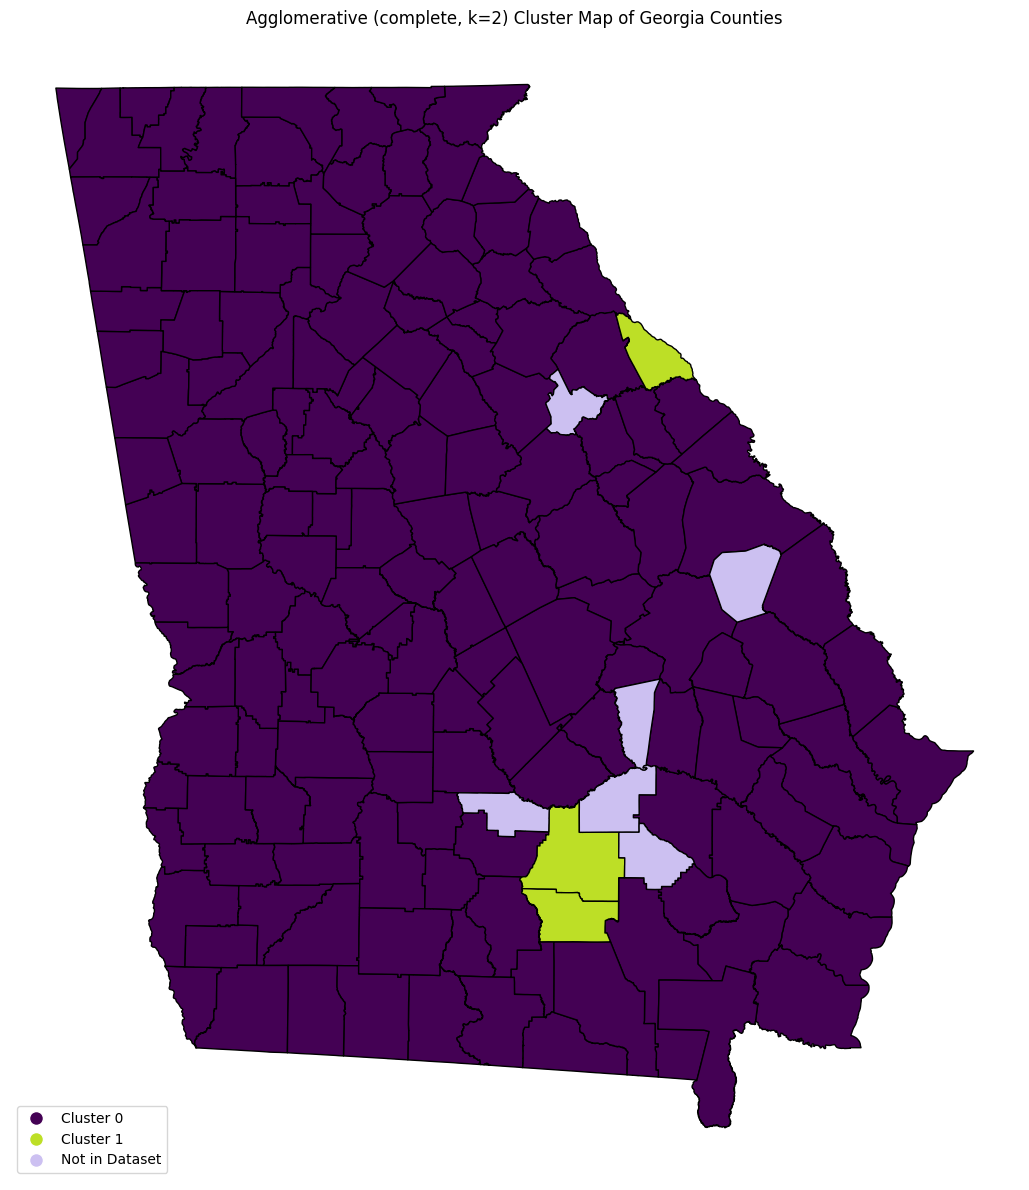

In [290]:
# Georgia map for Agglomerative clusters — works for any k and linkage
plot_ga_cluster_map(
    cluster_labels_agg,
    coefficients_df_cleaned['County'].values,
    title=f'Agglomerative ({agg_linkage}, k={agg_k}) Cluster Map of Georgia Counties',
)


In [291]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
import torch_geometric
from torch_geometric.data import Data

# Original DataFrame
feature_columns = coefficients_df_cleaned.columns.drop('County')
node_features = coefficients_df_cleaned[feature_columns].values

# Perform PCA using the selected component count
pca = PCA(n_components=PCA_COMPONENTS)
pca_features = pca.fit_transform(node_features)


# Convert PCA features to PyTorch tensor
pca_features = torch.tensor(pca_features, dtype=torch.float)

# Use a fixed k for KNN graph construction (consistency with prior runs)
KNN_K = 6
print(f"Using KNN k: {KNN_K}")

# Using k-nearest neighbors to construct edges based on PCA feature similarity
knn_graph = kneighbors_graph(pca_features.numpy(), KNN_K, mode='connectivity', include_self=False)

# Convert csr_matrix to COO (Coordinate) format to easily extract row and column indices
coo_graph = knn_graph.tocoo()

# Extract row and column indices which represent the edges
edge_index = torch.tensor(np.vstack((coo_graph.row, coo_graph.col)), dtype=torch.long)

# Create a graph data structure suitable for PyTorch Geometric GNN models
graph_data = Data(x=pca_features, edge_index=edge_index)

# Now, 'graph_data' is ready to be used as input to GNN models

Using KNN k: 6


In [292]:
import torch
import numpy as np
import random
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ---------------------------------------------------------------------------
# GCN grid search — ONLY searches learning rate and n_clusters.
# Architecture (out_channels=64, 4-layer encoder, 500 quick epochs) is FIXED
# so the search is fast and can't cause embedding collapse.
# ---------------------------------------------------------------------------

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv4 = GCNConv(2 * out_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv4(x, edge_index))
        x_reconstructed = self.decoder(x)
        return x_reconstructed, x  # x = latent embeddings

# Fixed architecture params (same as the final training cell)
in_channels = graph_data.x.size(1)
GCN_OUT_CHANNELS = 64
GCN_SEARCH_EPOCHS = 500

# Grid search over lr and n_clusters ONLY
learning_rates = [0.01, 0.05]
num_clusters_options = range(2, 8)

best_gcn_search = {
    'silhouette': -1,
    'davies_bouldin': None,
    'calinski_harabasz': None,
    'lr': None,
    'n_clusters': None,
}

for lr in learning_rates:
    set_seed(42)
    model = GCNAutoEncoder(in_channels, GCN_OUT_CHANNELS)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = torch.nn.MSELoss()

    model.train()
    for epoch in range(GCN_SEARCH_EPOCHS):
        optimizer.zero_grad()
        output, latent = model(graph_data.x, graph_data.edge_index)
        loss = loss_func(output, graph_data.x)
        loss.backward()
        optimizer.step()

    # IMPORTANT: cluster on the LATENT embeddings, NOT the reconstruction
    embeddings_np = latent.detach().numpy()

    # Try different k values on these fixed embeddings
    for n_clusters in num_clusters_options:
        labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(embeddings_np)
        sil = silhouette_score(embeddings_np, labels)
        dbi = davies_bouldin_score(embeddings_np, labels)
        chi = calinski_harabasz_score(embeddings_np, labels)

        if sil > best_gcn_search['silhouette']:
            best_gcn_search.update({
                'silhouette': sil,
                'davies_bouldin': dbi,
                'calinski_harabasz': chi,
                'lr': lr,
                'n_clusters': n_clusters,
            })

print(f"Best LR: {best_gcn_search['lr']}")
print(f"Best n_clusters: {best_gcn_search['n_clusters']}")
print(f"Best Silhouette: {best_gcn_search['silhouette']:.4f}")
print(f"Best DBI: {best_gcn_search['davies_bouldin']:.4f}")
print(f"Best CH: {best_gcn_search['calinski_harabasz']:.1f}")
print("Note: quick grid-search metrics (500 epochs) on GCN latent embeddings.")


Best LR: 0.05
Best n_clusters: 4
Best Silhouette: 0.5784
Best DBI: 0.6220
Best CH: 221.6
Note: quick grid-search metrics (500 epochs) on GCN latent embeddings.


Final GCN training: lr=0.05, out_channels=64, epochs=2000
Will cluster with k=4 (from grid search)
  Epoch 0: Loss 4.188437
  Epoch 200: Loss 2.901128
  Epoch 400: Loss 3.111670
  Epoch 600: Loss 3.005068
  Epoch 800: Loss 3.056642
  Epoch 1000: Loss 2.909668
  Epoch 1200: Loss 3.115218
  Epoch 1400: Loss 4.127653
  Epoch 1600: Loss 3.230430
  Epoch 1800: Loss 3.656210

Embedding std (mean across dims): 0.054125
Silhouette: 0.6954  DBI: 0.5049  CH: 1183.1
Note: metrics are computed on GCN latent embeddings (64-d), not raw features.

[GCN embeddings + KMeans (k=4)]
Total points: 153
Number of clusters (excluding noise): 4
Cluster sizes (excluding noise): {0: 57, 1: 42, 2: 31, 3: 23}
Silhouette Score: 0.6954445242881775
Davies-Bouldin Index: 0.5049136547435235
Calinski-Harabasz Index: 1183.0857103728265


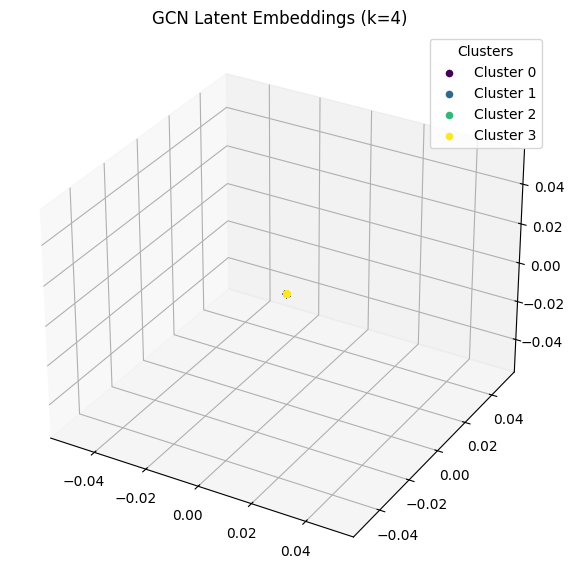

In [293]:
# ---------------------------------------------------------------------------
# Final GCN training — uses the best LR from grid search, trains for longer
# (2000 epochs) for better convergence.  n_clusters also from grid search.
#
# CRITICAL FIX: we cluster on the LATENT embeddings (64-d), NOT the
# reconstructed output (which is mapped back to original feature space).
# The old code had:  embeddings4 = output.detach().numpy()   ← WRONG
# The latent space is where graph structure is encoded.
# ---------------------------------------------------------------------------

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

set_seed(42)

# Use best LR from grid search; architecture matches the search cell
best_lr = best_gcn_search['lr']
best_k  = best_gcn_search['n_clusters']
GCN_FINAL_EPOCHS = 2000

print(f"Final GCN training: lr={best_lr}, out_channels={GCN_OUT_CHANNELS}, epochs={GCN_FINAL_EPOCHS}")
print(f"Will cluster with k={best_k} (from grid search)")

model = GCNAutoEncoder(in_channels, GCN_OUT_CHANNELS)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
loss_func = torch.nn.MSELoss()

model.train()
for epoch in range(GCN_FINAL_EPOCHS):
    optimizer.zero_grad()
    output, latent = model(graph_data.x, graph_data.edge_index)
    loss = loss_func(output, graph_data.x)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"  Epoch {epoch}: Loss {loss.item():.6f}")

# *** Use the LATENT embeddings (64-d), NOT the reconstruction ***
embeddings4 = latent.detach().numpy()

# Quick sanity check: if embeddings collapsed, warn the user
emb_std = embeddings4.std(axis=0).mean()
print(f"\nEmbedding std (mean across dims): {emb_std:.6f}")
if emb_std < 1e-4:
    print("⚠ WARNING: embeddings have near-zero variance — possible collapse.")

# Cluster on the latent embeddings
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels4 = kmeans.fit_predict(embeddings4)

# Evaluate
unique_labels = np.unique(cluster_labels4)
if len(unique_labels) < 2:
    print("Only one cluster was found; metrics cannot be computed.")
else:
    silhouette = silhouette_score(embeddings4, cluster_labels4)
    davies_bouldin = davies_bouldin_score(embeddings4, cluster_labels4)
    calinski_harabasz = calinski_harabasz_score(embeddings4, cluster_labels4)
    print(f"Silhouette: {silhouette:.4f}  DBI: {davies_bouldin:.4f}  CH: {calinski_harabasz:.1f}")

print("Note: metrics are computed on GCN latent embeddings (64-d), not raw features.")
summarize_clusters(cluster_labels4, embeddings4, method_name=f"GCN embeddings + KMeans (k={best_k})")

# 3D visualization (first 3 dimensions of the latent space)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.linspace(0, 1, best_k))
for i, color in enumerate(colors):
    mask = cluster_labels4 == i
    ax.scatter(embeddings4[mask, 0], embeddings4[mask, 1], embeddings4[mask, 2],
               c=[color], label=f'Cluster {i}')
ax.set_title(f'GCN Latent Embeddings (k={best_k})')
ax.legend(title="Clusters")
plt.show()


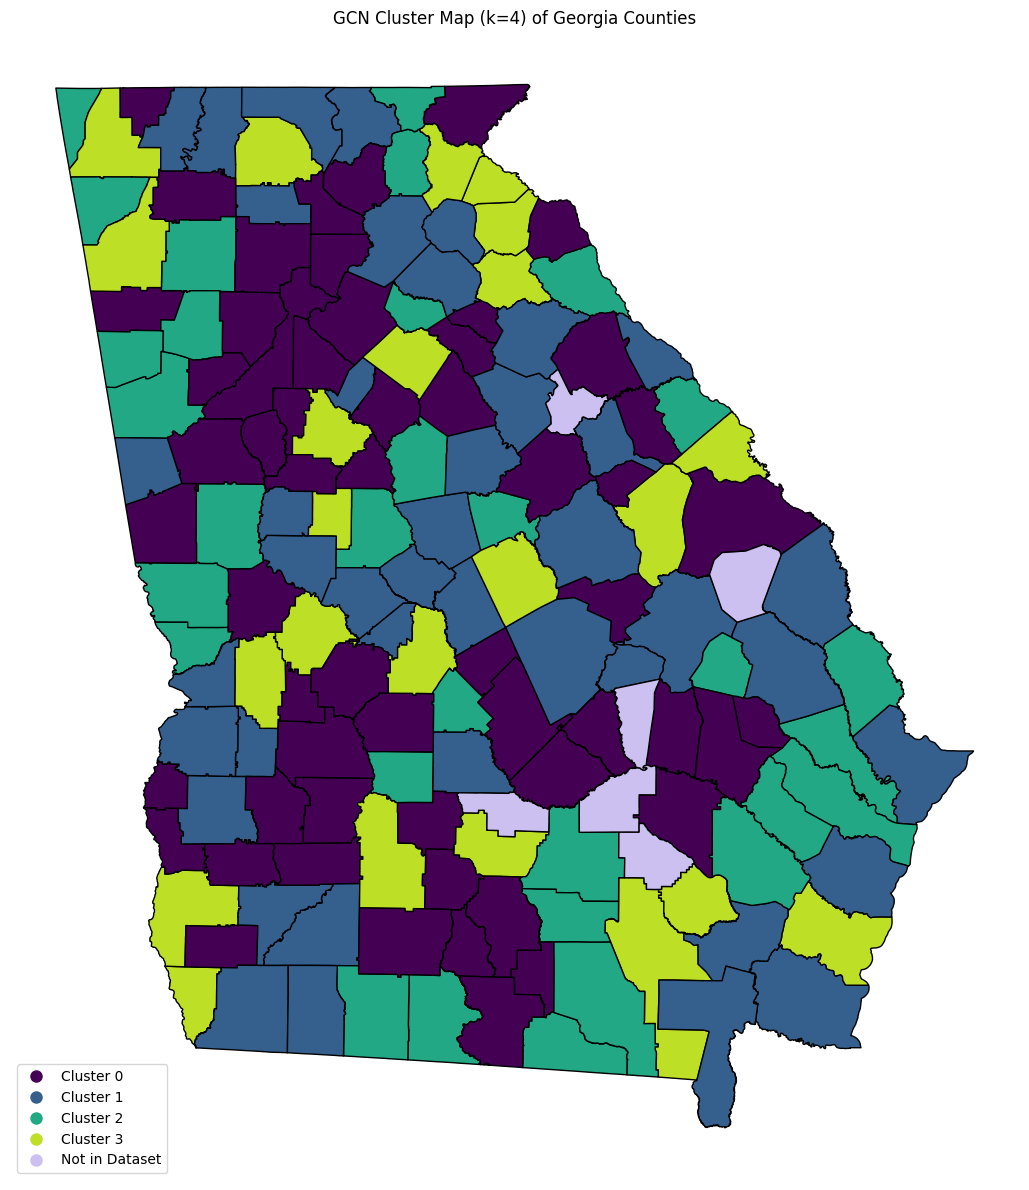

In [294]:
# Georgia map for GCN clusters — uses the reusable helper
plot_ga_cluster_map(
    cluster_labels4,
    coefficients_df_cleaned['County'].values,
    title=f'GCN Cluster Map (k={best_k}) of Georgia Counties',
)


In [295]:
from scipy.stats import f_oneway
import pandas as pd

# Use GCN clusters for post-clustering statistical analysis
coefficients_df_cleaned['Cluster'] = cluster_labels4

# Let's say 'features' is the list of column names for the features
# Exclude 'Cluster' and 'County' column from the features list if present
features = coefficients_df_cleaned.columns.drop(['Cluster', 'County'])

# Initialize an empty list to hold the results
anova_results_list = []

# Guard: ANOVA needs at least 2 clusters
unique_clusters = coefficients_df_cleaned['Cluster'].unique()
if len(unique_clusters) < 2:
    print("ANOVA skipped: only one cluster was found, need at least 2 clusters.")
else:
    # Loop through each feature and perform ANOVA
    for feature in features:
        # Get the groups based on clusters
        groups = [
            coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster][feature]
            for cluster in unique_clusters
        ]
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*groups)

        # Determine if the null hypothesis can be rejected
        reject_null = p_value < 0.05

        # Append results to the list
        anova_results_list.append({
            'Feature': feature,
            'F-Statistic': f_statistic,
            'p-value': p_value,
            'Reject Null': reject_null
        })

    # Create a DataFrame from the results list
    anova_results_df = pd.DataFrame(anova_results_list)

    # Print the DataFrame
    print(anova_results_df)

    # Optional: Save the results to a CSV file
    anova_results_df.to_csv('./anova_results.csv', index=False)


                                           Feature  F-Statistic       p-value  \
0                        Pct_Children_in_Poverty_a     3.604841  1.493279e-02   
1                        Pct_Children_in_Poverty_b     3.607676  1.487829e-02   
2                        Pct_Children_in_Poverty_c     3.610472  1.482475e-02   
3                         Pct_Excessive_Drinking_a     3.663113  1.385186e-02   
4                         Pct_Excessive_Drinking_b     3.664689  1.382374e-02   
5                         Pct_Excessive_Drinking_c     3.666260  1.379577e-02   
6                                    Pct_Smokers_a     2.956451  3.441691e-02   
7                                    Pct_Smokers_b     2.956046  3.443482e-02   
8                                    Pct_Smokers_c     2.955643  3.445268e-02   
9                                 Pct_Unemployed_a     0.957409  4.146232e-01   
10                                Pct_Unemployed_b     0.955328  4.156178e-01   
11                          

/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/2909185449.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels4


In [296]:
from tabulate import tabulate

# Convert your ANOVA results DataFrame into a pretty-printed table
pretty_table = tabulate(anova_results_df, headers='keys', tablefmt='pretty', showindex=False)

# Print the table
print(pretty_table)


+------------------------------------------------+---------------------+------------------------+-------------+
|                    Feature                     |     F-Statistic     |        p-value         | Reject Null |
+------------------------------------------------+---------------------+------------------------+-------------+
|           Pct_Children_in_Poverty_a            | 3.6048411083991763  |  0.014932785878959642  |    True     |
|           Pct_Children_in_Poverty_b            |  3.607676468467945  |  0.014878291880923175  |    True     |
|           Pct_Children_in_Poverty_c            |  3.610472197632102  |  0.014824754067794045  |    True     |
|            Pct_Excessive_Drinking_a            |  3.663113315247627  |  0.013851858414862538  |    True     |
|            Pct_Excessive_Drinking_b            | 3.6646893198936046  |  0.013823736371987501  |    True     |
|            Pct_Excessive_Drinking_c            | 3.6662599007918826  |  0.01379576786987466   |    Tru

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for significant features where the null hypothesis was rejected
significant_features = anova_results_df[anova_results_df['Reject Null']]['Feature'].tolist()

# Create a DataFrame that includes the cluster labels and the significant features
df_significant = coefficients_df_cleaned[['Cluster'] + significant_features]



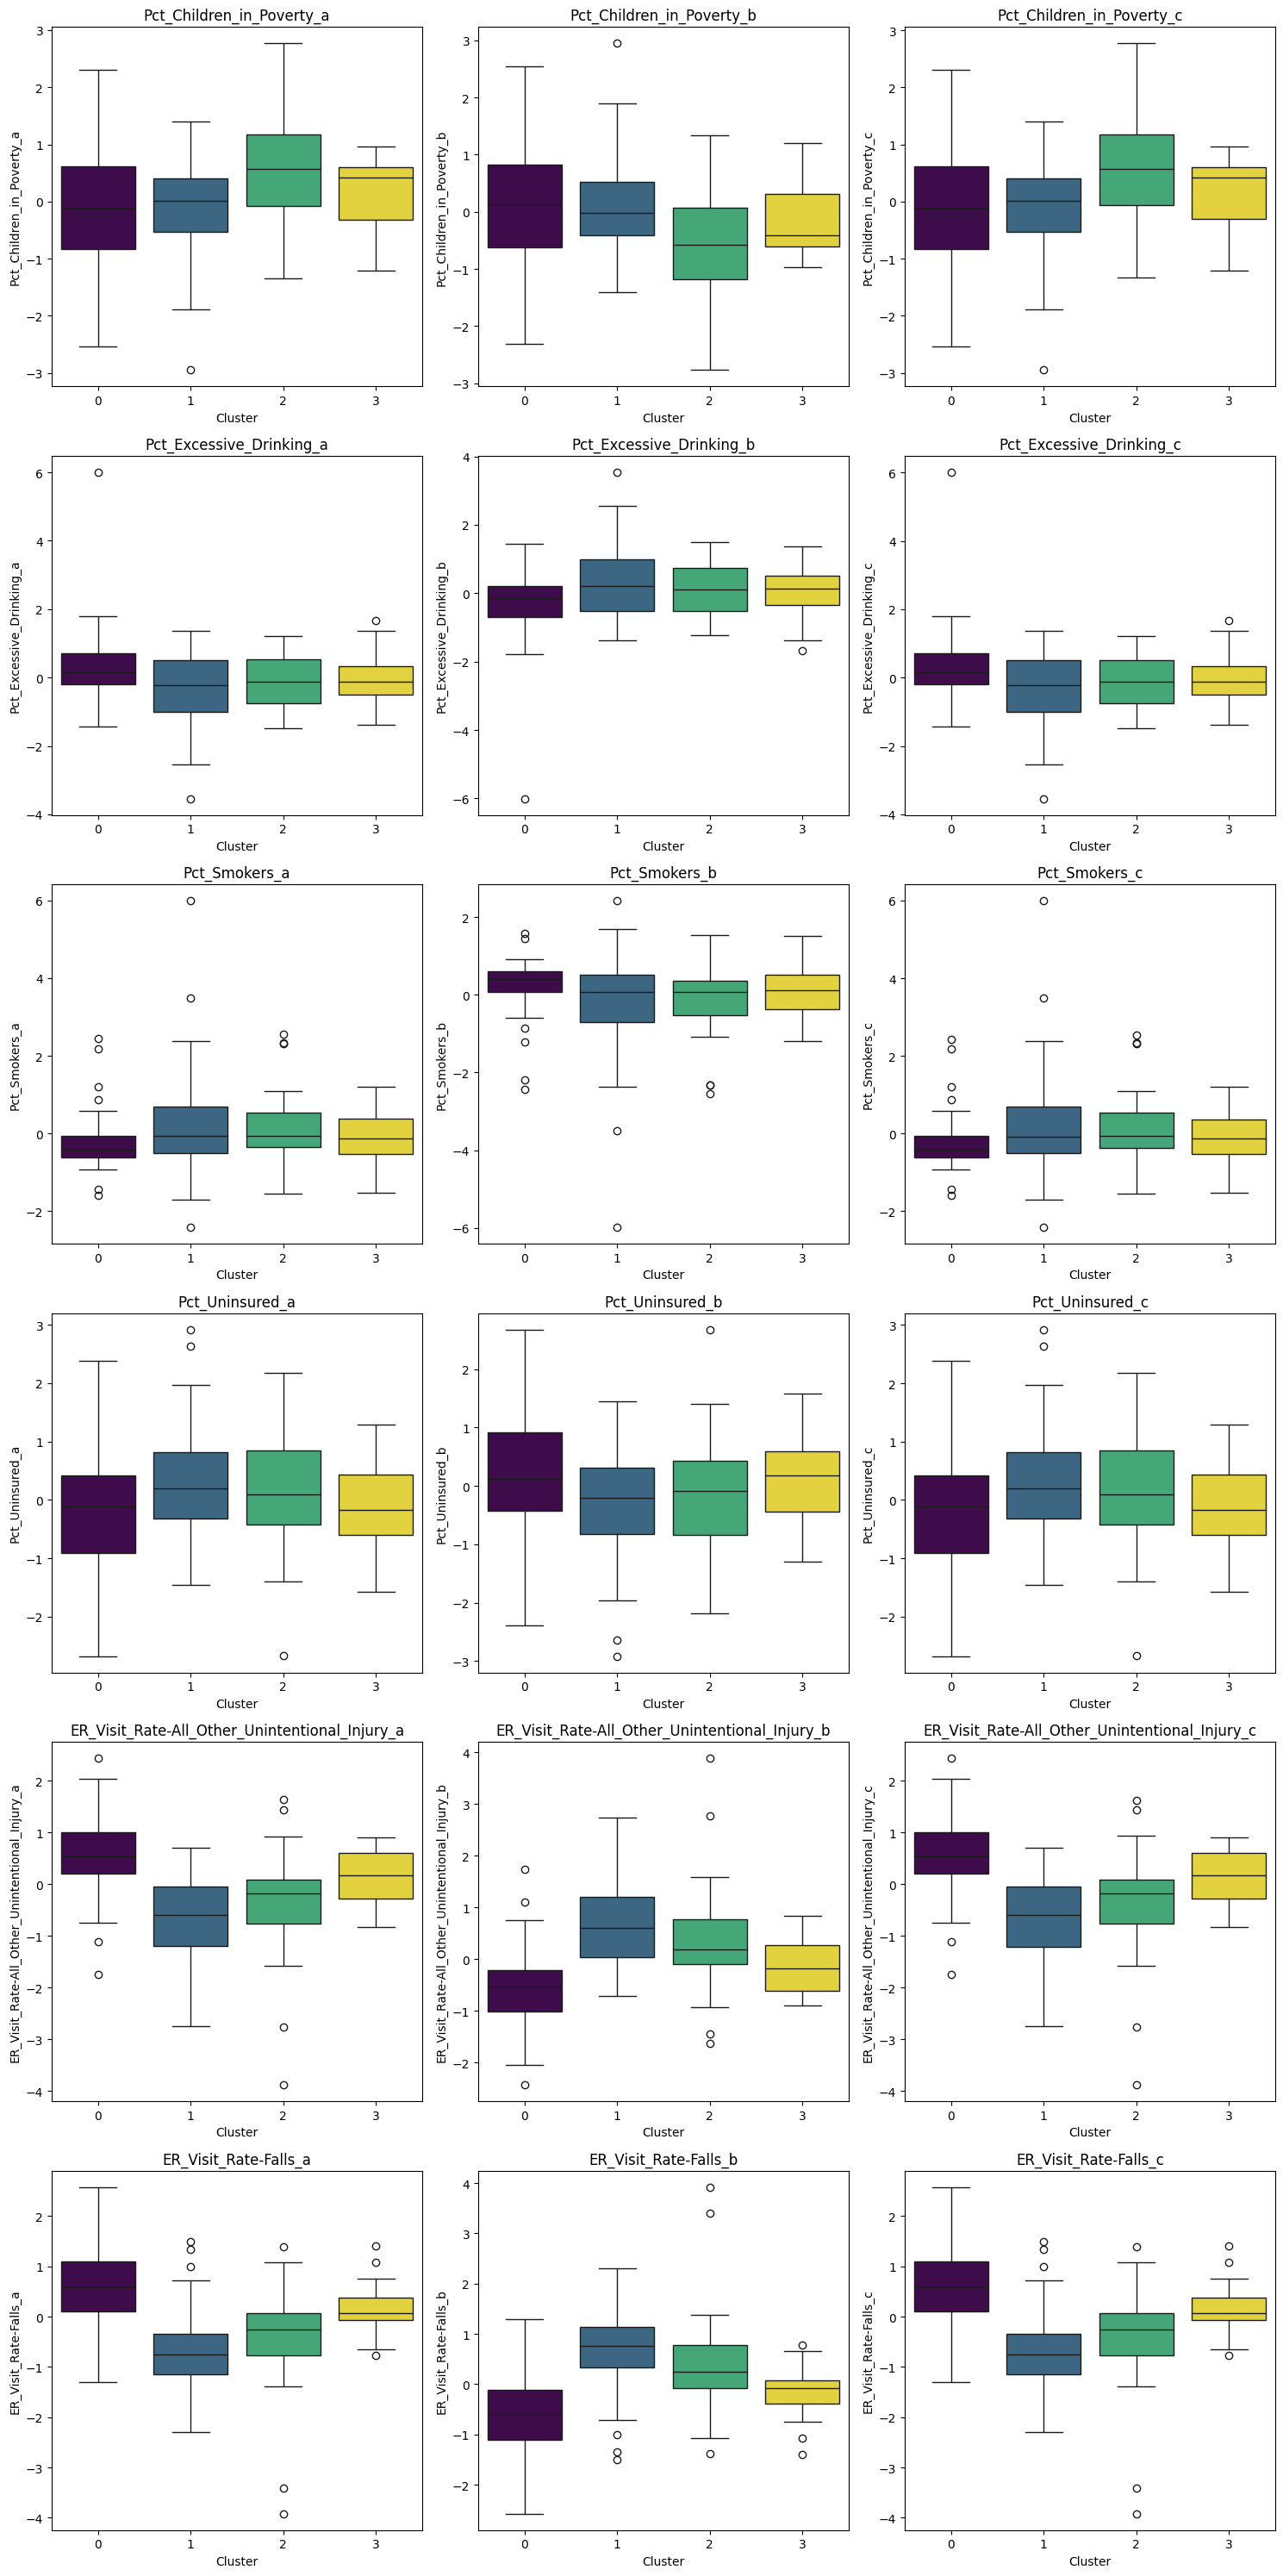

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'significant_features' and cluster labels are defined
num_features = len(significant_features)
num_columns = 3  # Number of columns in the grid
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate rows needed, rounding up

# Determine the number of unique clusters
unique_clusters = np.unique(coefficients_df_cleaned['Cluster'])

# Create a color palette from a colormap and convert it to list
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters))).tolist()

# Create a large figure to hold the subplots
plt.figure(figsize=(15, 5 * num_rows))

# Iterate over the significant features to create a subplot for each
for i, feature in enumerate(significant_features, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(x='Cluster', y=feature, data=coefficients_df_cleaned, hue='Cluster', palette=colors, dodge=False, legend=False)
    plt.title(feature)
    plt.legend([],[], frameon=False)  # Disable the legend
    plt.tight_layout()

plt.show()


In [299]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming 'coefficients_df_cleaned' is your DataFrame and 'significant_features' lists the features of interest
clusters = coefficients_df_cleaned['Cluster'].unique()
overall_means = coefficients_df_cleaned[significant_features].mean()

cluster_descriptions = {}

for cluster in sorted(clusters):
    cluster_data = coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster]
    cluster_means = cluster_data[significant_features].mean()
    
    # Initialize lists to store high and low significant features
    significant_high = []
    significant_low = []
    
    # Perform t-tests and determine significance
    for feature in significant_features:
        stat, p_value = ttest_1samp(cluster_data[feature], overall_means[feature])
        
        # Consider the feature significant if p-value < 0.05
        if p_value < 0.05:
            if cluster_means[feature] > overall_means[feature]:
                significant_high.append(feature)
            elif cluster_means[feature] < overall_means[feature]:
                significant_low.append(feature)
    
    # Forming the profile description
    description = f"Cluster {cluster} characteristics:\n"
    if significant_high:
        description += f"Significantly higher in: {', '.join(significant_high)}\n"
    if significant_low:
        description += f"Significantly lower in: {', '.join(significant_low)}\n"
    
    cluster_descriptions[cluster] = description

# Print all cluster descriptions
for cluster, description in cluster_descriptions.items():
    print(description)


Cluster 0 characteristics:
Significantly higher in: Pct_Excessive_Drinking_a, Pct_Excessive_Drinking_c, Pct_Smokers_b, Pct_Uninsured_b, ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_c
Significantly lower in: Pct_Excessive_Drinking_b, Pct_Smokers_a, Pct_Smokers_c, Pct_Uninsured_a, Pct_Uninsured_c, ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-Falls_b

Cluster 1 characteristics:
Significantly higher in: Pct_Uninsured_a, Pct_Uninsured_c, ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-Falls_b
Significantly lower in: Pct_Uninsured_b, ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_c

Cluster 2 characteristics:
Significantly higher in: Pct_Children_in_Poverty_a, Pct_Children_in_Poverty_c, ER_Visit_Rate-Falls_b
Significantly lower in: Pct_Children_in_Poverty_b, ER_Visit_Rate-Falls_

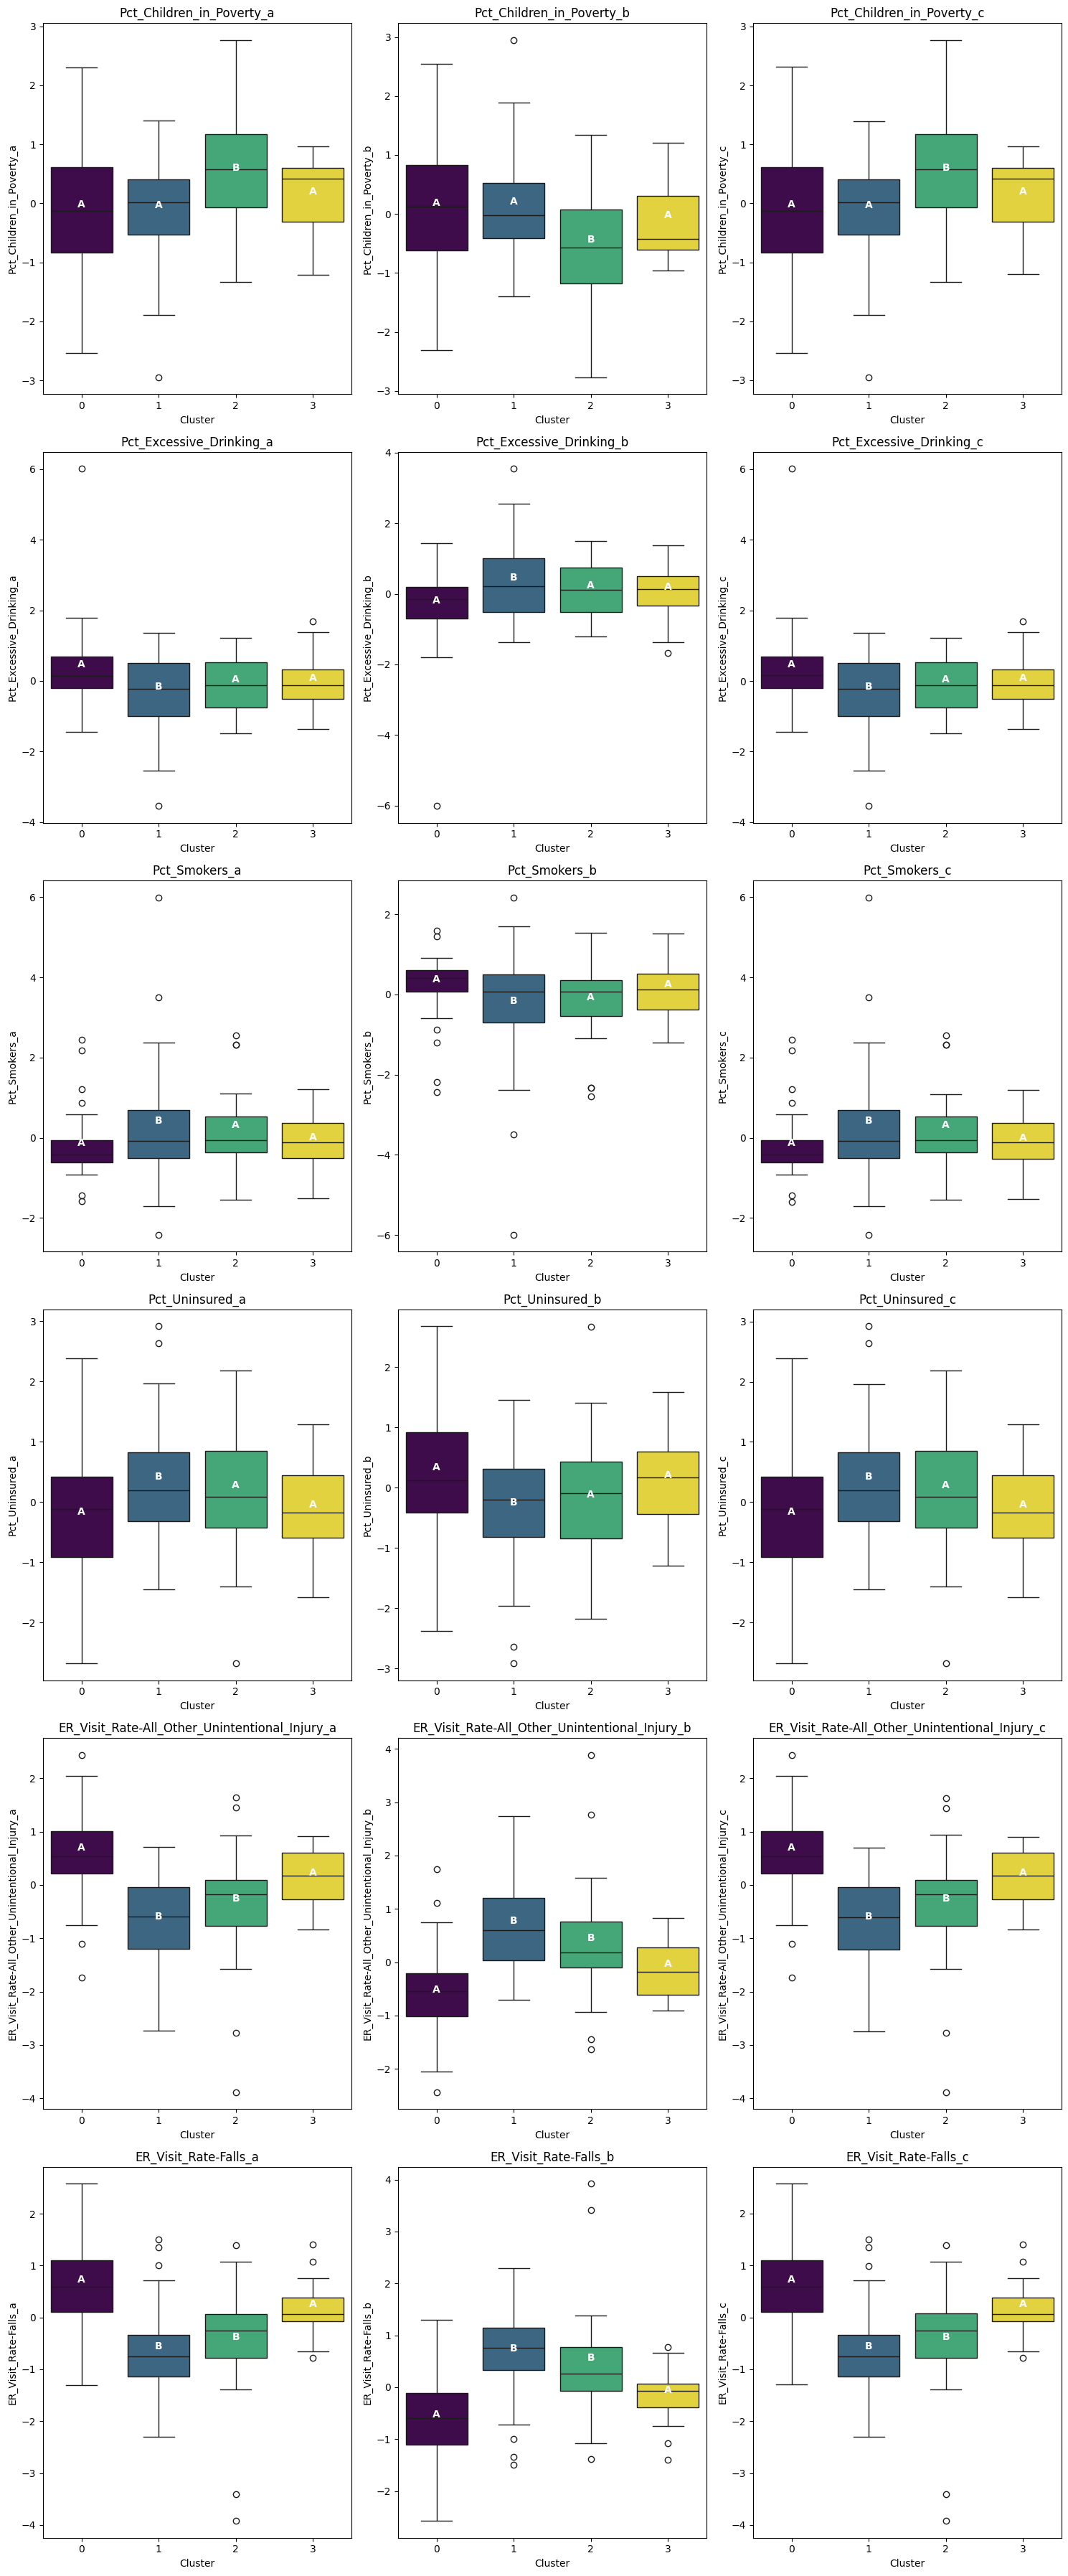

In [300]:
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'coefficients_df_cleaned' and 'significant_features' are already defined

# Dictionary to store post-hoc results and group letters
post_hoc_results = {}
group_letters = {}

# Creating a color map for the clusters
unique_clusters = np.unique(coefficients_df_cleaned['Cluster'])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters))).tolist()  # Convert to list for compatibility

for feature in significant_features:
    # Prepare the data for Tukey's test
    tukey_data = coefficients_df_cleaned[[feature, 'Cluster']].dropna()
    tukey_result = pairwise_tukeyhsd(endog=tukey_data[feature], groups=tukey_data['Cluster'], alpha=0.05)
    post_hoc_results[feature] = tukey_result

    # Parse the summary data to DataFrame
    summary_data = pd.DataFrame(tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
    summary_data['reject'] = summary_data['reject'].astype(bool)

    # Group clusters based on non-significant results
    clusters = tukey_result.groupsunique
    connections = {cluster: set() for cluster in clusters}
    
    for _, row in summary_data.iterrows():
        if not row['reject']:
            connections[row['group1']].add(row['group2'])
            connections[row['group2']].add(row['group1'])

    group_dict = {}
    current_group = 'A'
    for cluster in clusters:
        if cluster not in group_dict:
            groups_to_assign = [cluster] + list(connections[cluster])
            for grp in groups_to_assign:
                if grp not in group_dict:
                    group_dict[grp] = current_group
            current_group = chr(ord(current_group) + 1)

    group_letters[feature] = group_dict

num_features = len(significant_features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns

plt.figure(figsize=(15, 6 * num_rows))

for i, feature in enumerate(significant_features, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(x='Cluster', y=feature, data=coefficients_df_cleaned, hue='Cluster', palette=colors, dodge=False)
    plt.legend([],[], frameon=False)
    plt.title(feature)

    # Adjust text positioning
    means = coefficients_df_cleaned.groupby('Cluster')[feature].mean()
    for cluster in clusters:
        x_pos = list(clusters).index(cluster)
        plt.text(x_pos, means[cluster], group_letters[feature].get(cluster, ''), color='white', weight='bold', ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout to make room for title and axis labels

plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/3701998140.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}


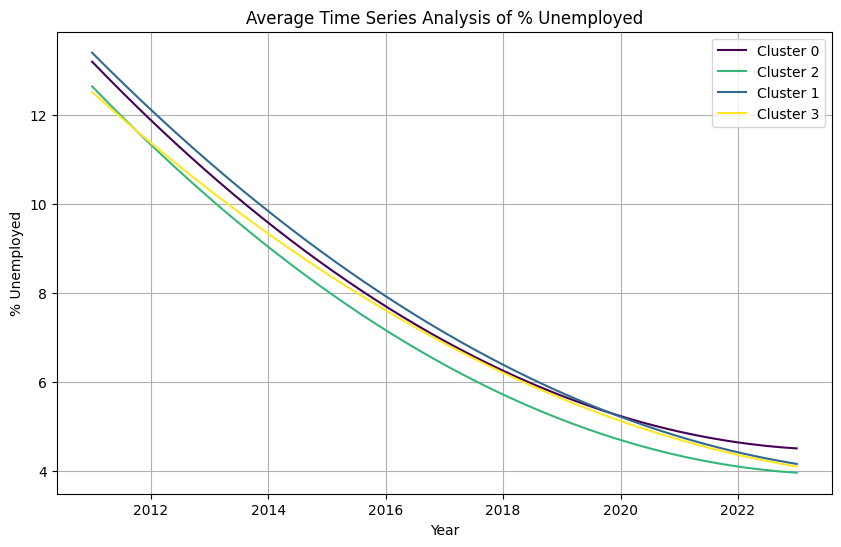

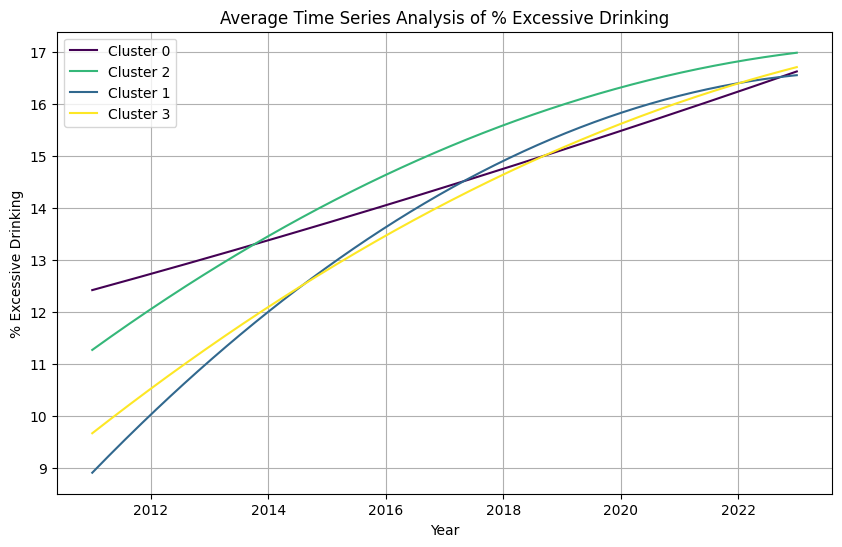

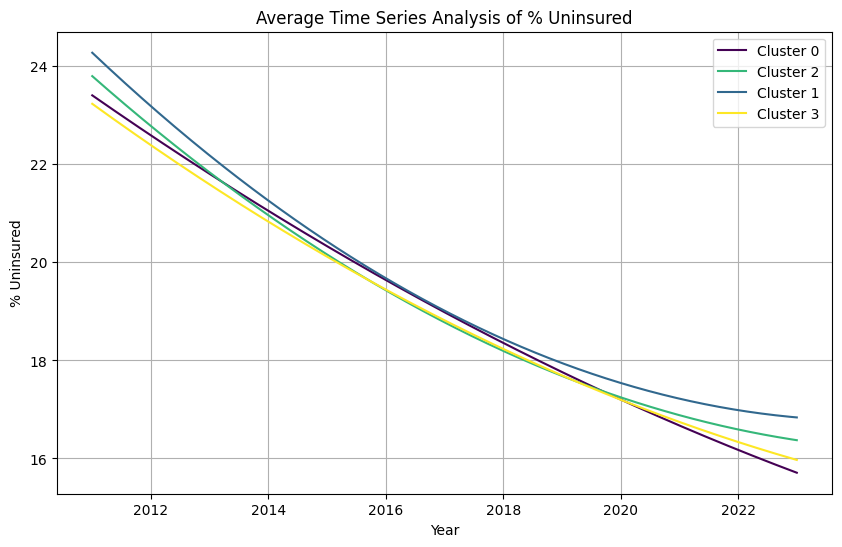

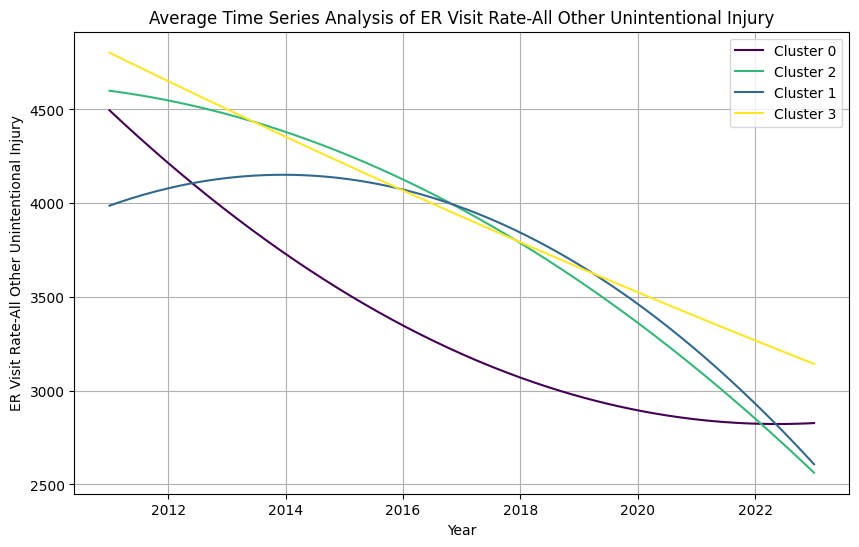

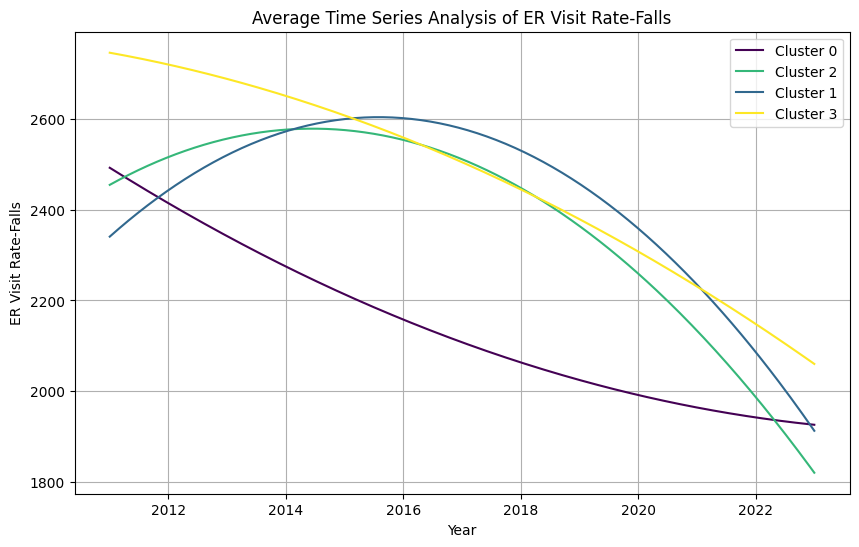

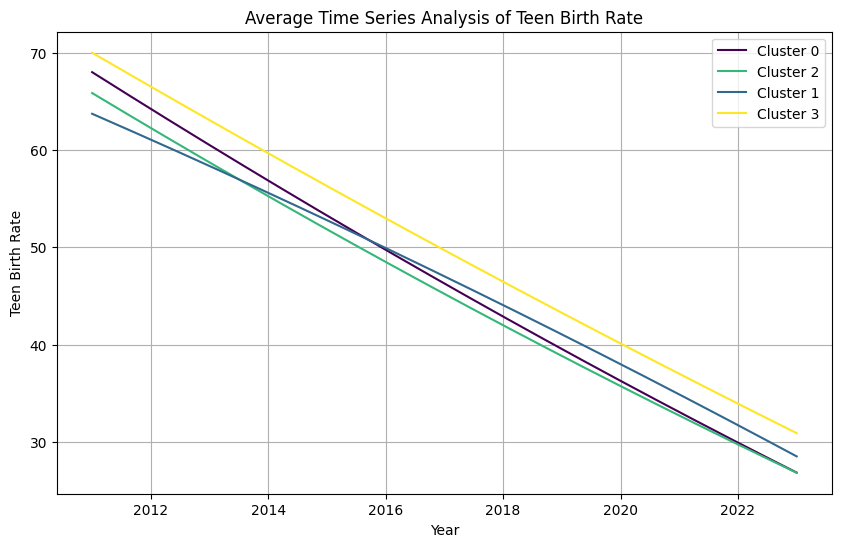

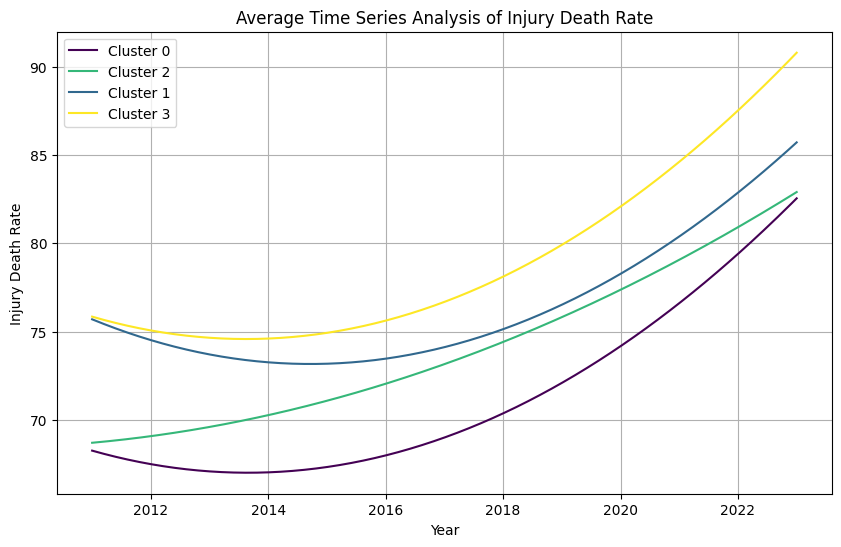

In [301]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Load the county data for year-wise analysis
cleaned_data_table = pd.read_csv("pivot_wide_format_data_imputed_timeseries.csv")
filtered_data_table = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.3].copy()
filtered_data_table = filtered_data_table.merge(coefficients_df_cleaned[['County', 'Cluster']], on='County', how='left')


# Define the color map for clusters
clusters = coefficients_df_cleaned['Cluster'].unique()
cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}

def plot_average_by_cluster(data, feature_name):
    plt.figure(figsize=(10, 6))
    legend_added = set()
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        
        # Drop any rows where 'feature_name' is NaN
        mean_data = mean_data.dropna(subset=[feature_name])

        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name].values
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            plt.plot(X_seq, model.predict(X_seq), label=f"Cluster {cluster}" if cluster not in legend_added else "", color=cluster_color_map[cluster])
            legend_added.add(cluster)

    plt.title(f"Average Time Series Analysis of {feature_name}")
    plt.xlabel("Year")
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.show()

original_features = ["% Unemployed", "% Excessive Drinking", "% Uninsured", "ER Visit Rate-All Other Unintentional Injury", "ER Visit Rate-Falls", 
                     "Teen Birth Rate", "Injury Death Rate"]
# Plot each significant feature for year-wise analysis
for feature in original_features:
    plot_average_by_cluster(filtered_data_table, feature)


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/2953579061.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/2953579061.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_data.dropna(subset=[feature_name], inplace=True)
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_53529/2953579061.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

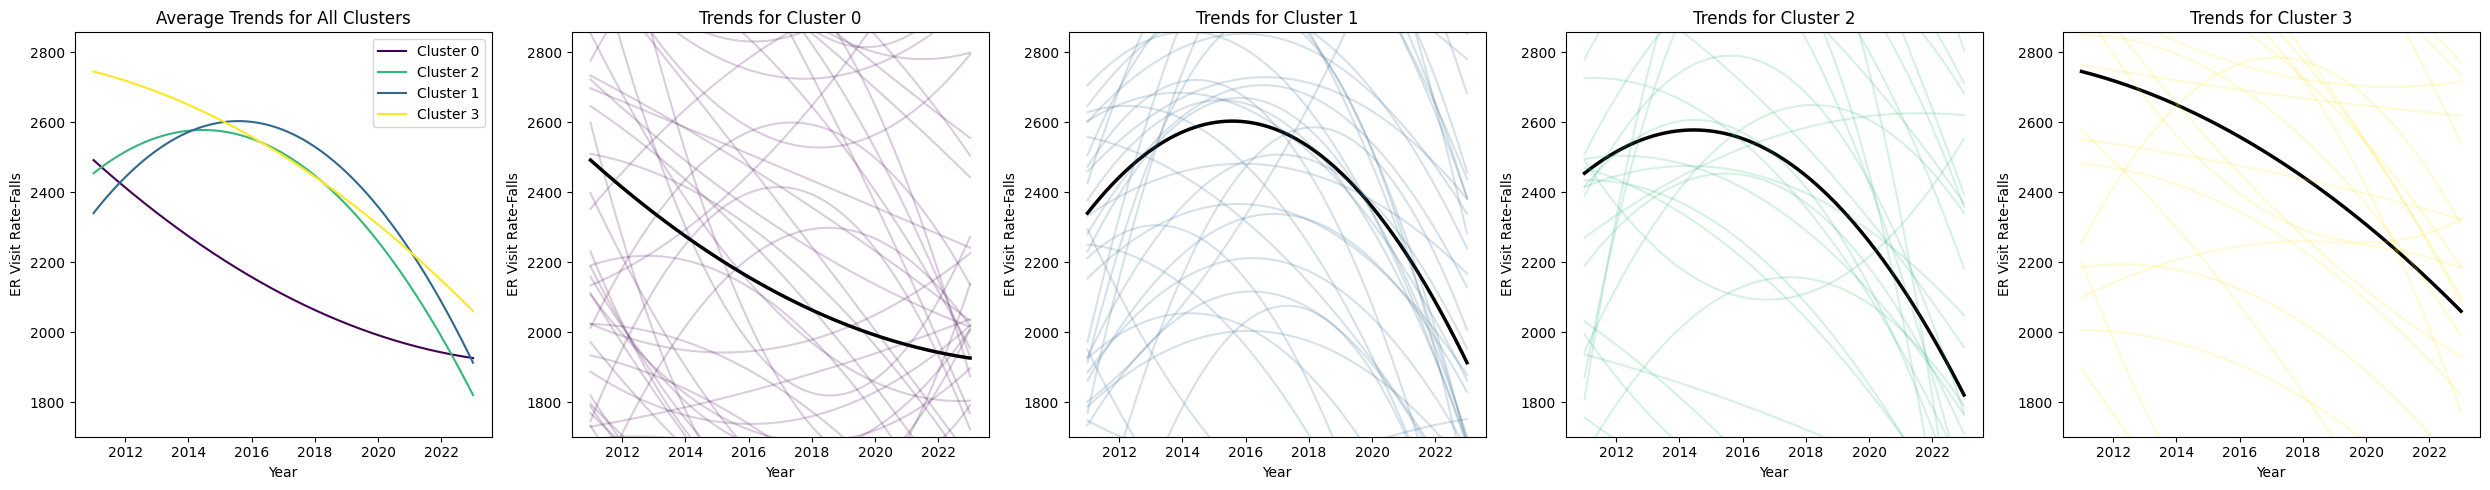

In [302]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def plot_trend_lines(data, feature_name, clusters, cluster_color_map):
    plt.figure(figsize=(25, 5))  # Adjust the figure size for a single row
    
    # Global min/max determination
    global_min = float('inf')
    global_max = float('-inf')

    # Calculate global min and max from the average plot data
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        mean_data.dropna(subset=[feature_name], inplace=True)
        
        if not mean_data.empty:
            current_min = mean_data[feature_name].min()
            current_max = mean_data[feature_name].max()
            global_min = min(global_min, current_min)
            global_max = max(global_max, current_max)

    # Plot 1: All clusters average
    ax1 = plt.subplot(1, len(clusters) + 1, 1)  # Adjust subplot for single row
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        mean_data.dropna(subset=[feature_name], inplace=True)
        
        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name]
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            ax1.plot(X_seq, model.predict(X_seq), label=f"Cluster {cluster}", color=cluster_color_map[cluster])

    ax1.set_title("Average Trends for All Clusters")
    ax1.set_xlabel("Year")
    ax1.set_ylabel(feature_name)
    ax1.set_ylim(global_min, global_max)
    ax1.legend()

    # Plots 2-N: Individual clusters with darker average line
    for i, cluster in enumerate(sorted(clusters), start=2):
        ax = plt.subplot(1, len(clusters) + 1, i)
        cluster_data = data[data['Cluster'] == cluster]
        
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        mean_data.dropna(subset=[feature_name], inplace=True)
        
        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name]
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            ax.plot(X_seq, model.predict(X_seq), label="Average", color='black', linewidth=2.5)
            
            for county in cluster_data['County'].unique():
                county_data = cluster_data[cluster_data['County'] == county]
                county_data.dropna(subset=[feature_name], inplace=True)
                
                if not county_data.empty and len(county_data) > 1:
                    X = county_data['Year'].values.reshape(-1, 1)
                    Y = county_data[feature_name]
                    model.fit(X, Y)
                    X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
                    ax.plot(X_seq, model.predict(X_seq), color=cluster_color_map[cluster], alpha=0.2)

        ax.set_title(f"Trends for Cluster {cluster}")
        ax.set_xlabel("Year")
        ax.set_ylabel(feature_name)
        ax.set_ylim(global_min, global_max)

    plt.tight_layout()
    plt.show()

# Assuming 'filtered_data_table' and 'coefficients_df_cleaned' are correctly defined and available
clusters = coefficients_df_cleaned['Cluster'].unique()
cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}
plot_trend_lines(filtered_data_table, "ER Visit Rate-Falls", clusters, cluster_color_map)


Comparison params: KMeans k=3, Agg linkage=complete k=2, DBSCAN grid-searched per space (noise cap=30%)

=== Clustering Comparison Summary ===
                       space                        method  n_clusters  noise_pct  silhouette  davies_bouldin  calinski_harabasz         cluster_sizes
                Raw PCA (5D)                  KMeans (k=3)           3   0.000000    0.161207        1.780381          24.155817 {0: 69, 1: 69, 2: 15}
                Raw PCA (5D) Agglomerative (complete, k=2)           2   0.000000    0.480746        1.288990          10.006349        {0: 150, 1: 3}
                Raw PCA (5D)        DBSCAN (eps=5.5, ms=2)           2   0.013072    0.483744        0.656065          11.131357        {0: 149, 1: 2}
GCN embeddings (64-D latent)                  KMeans (k=3)           3   0.000000    0.690541        0.514075         912.242935 {0: 63, 1: 52, 2: 38}
GCN embeddings (64-D latent) Agglomerative (complete, k=2)           2   0.000000    0.670035        0

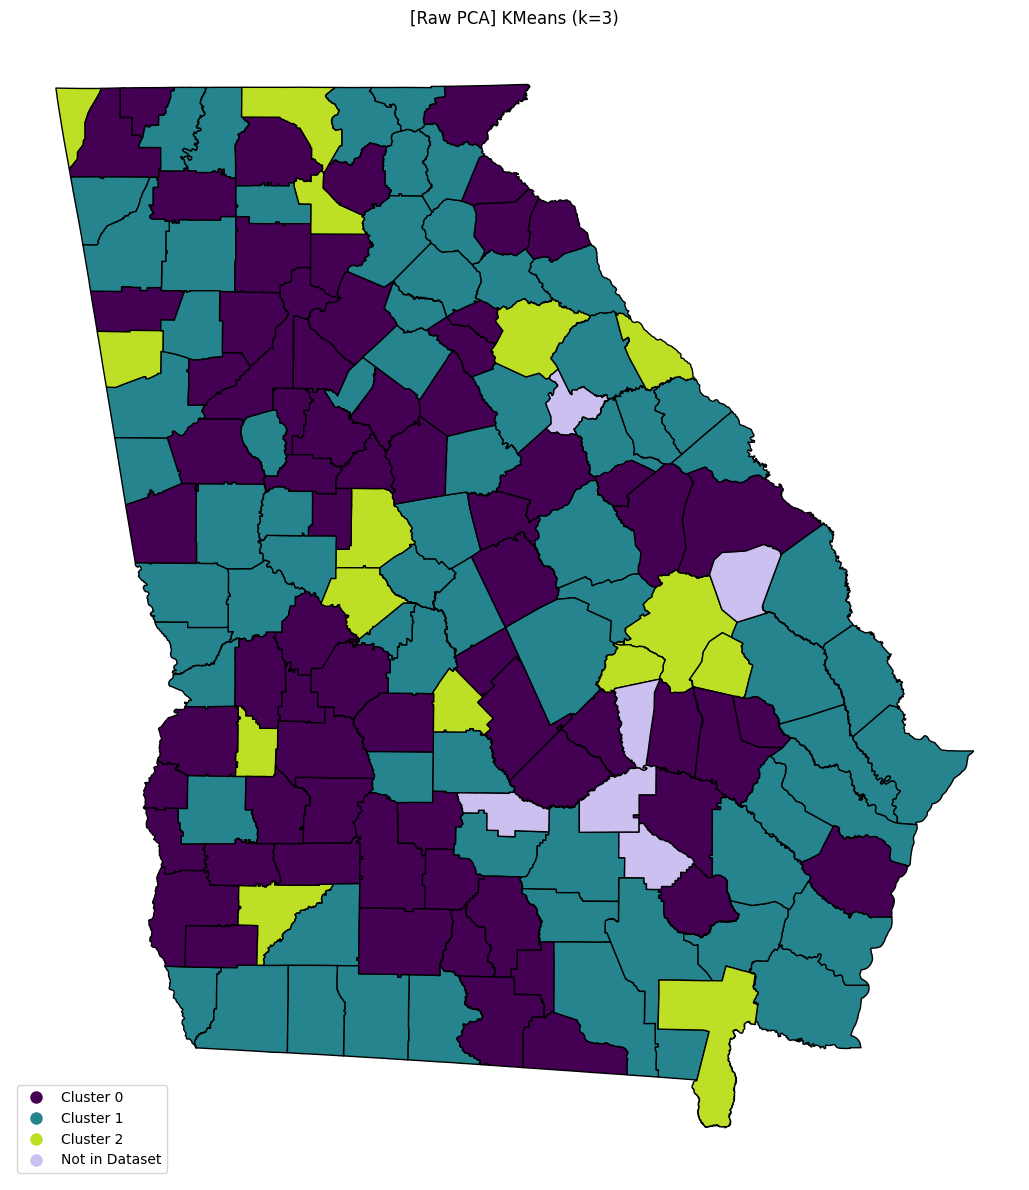

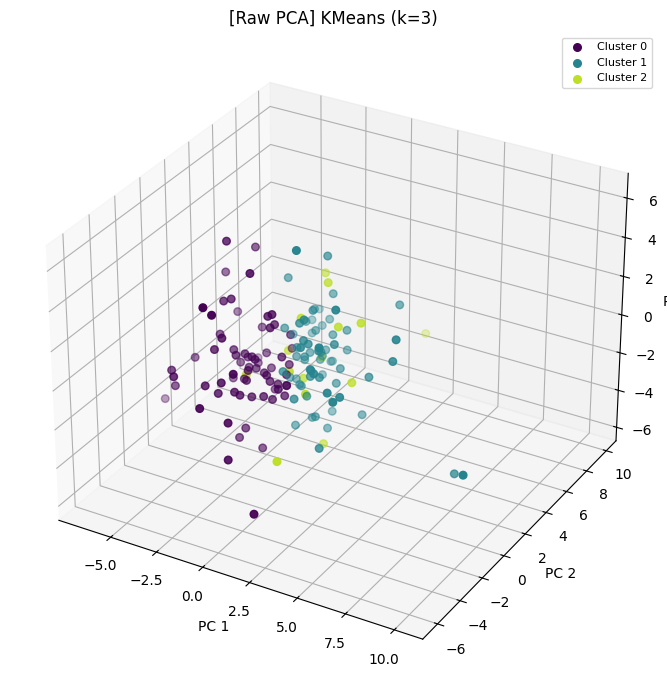

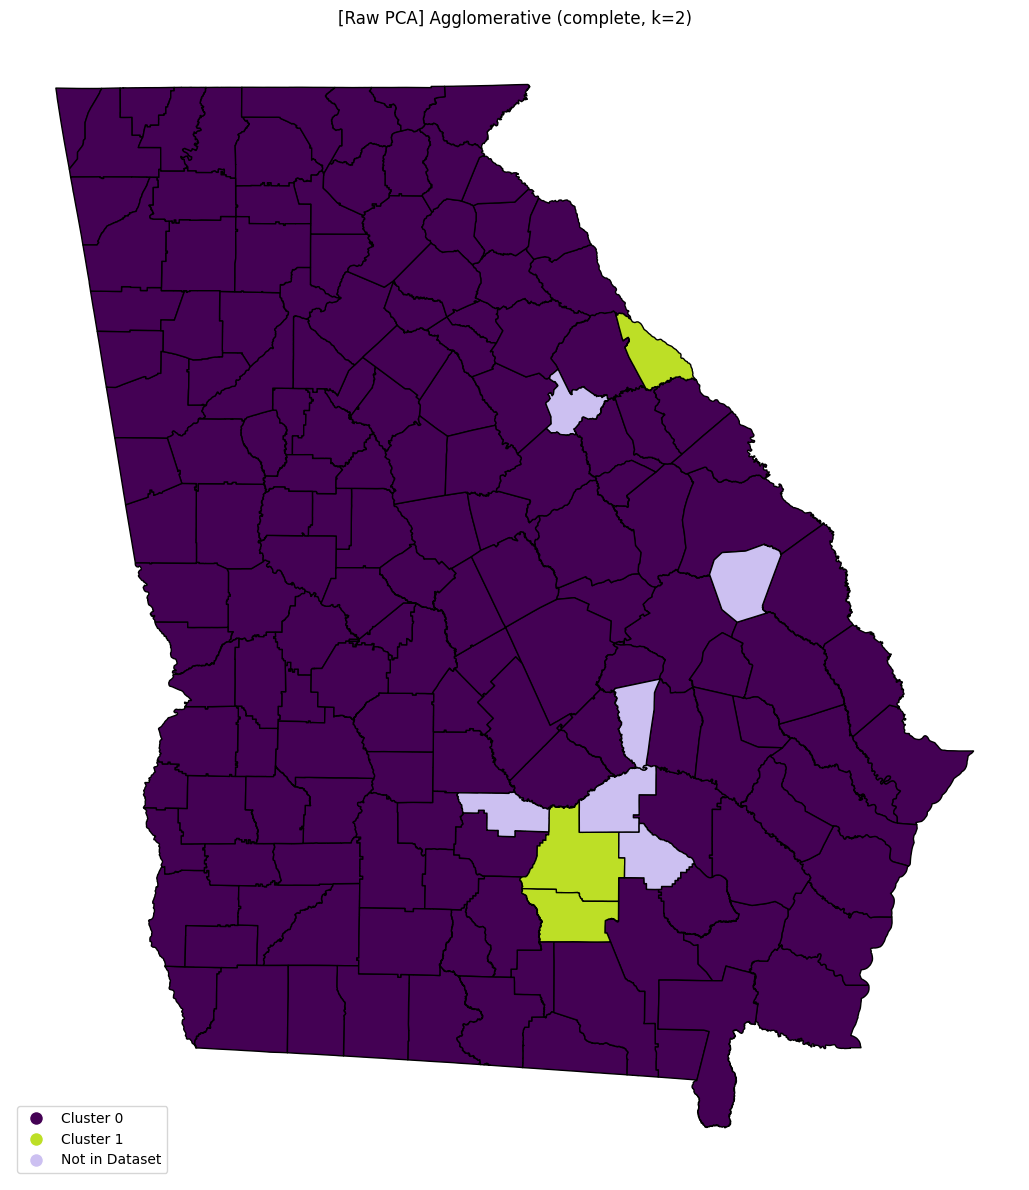

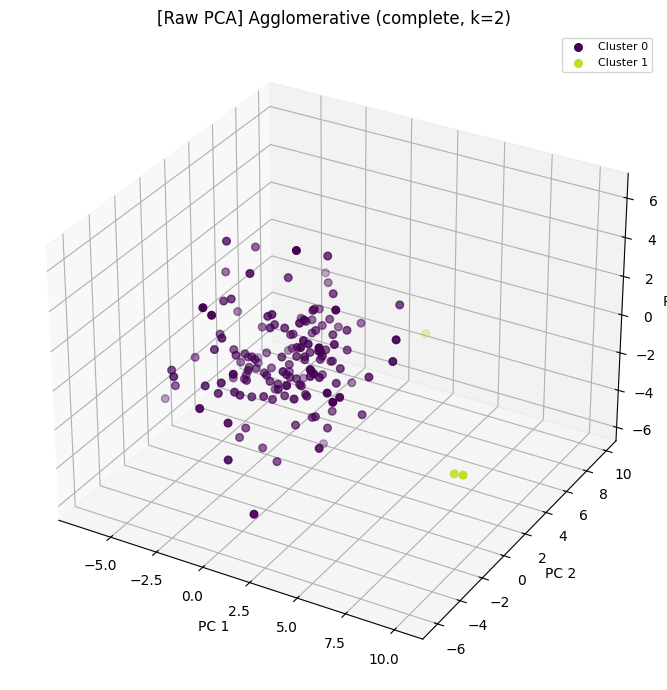

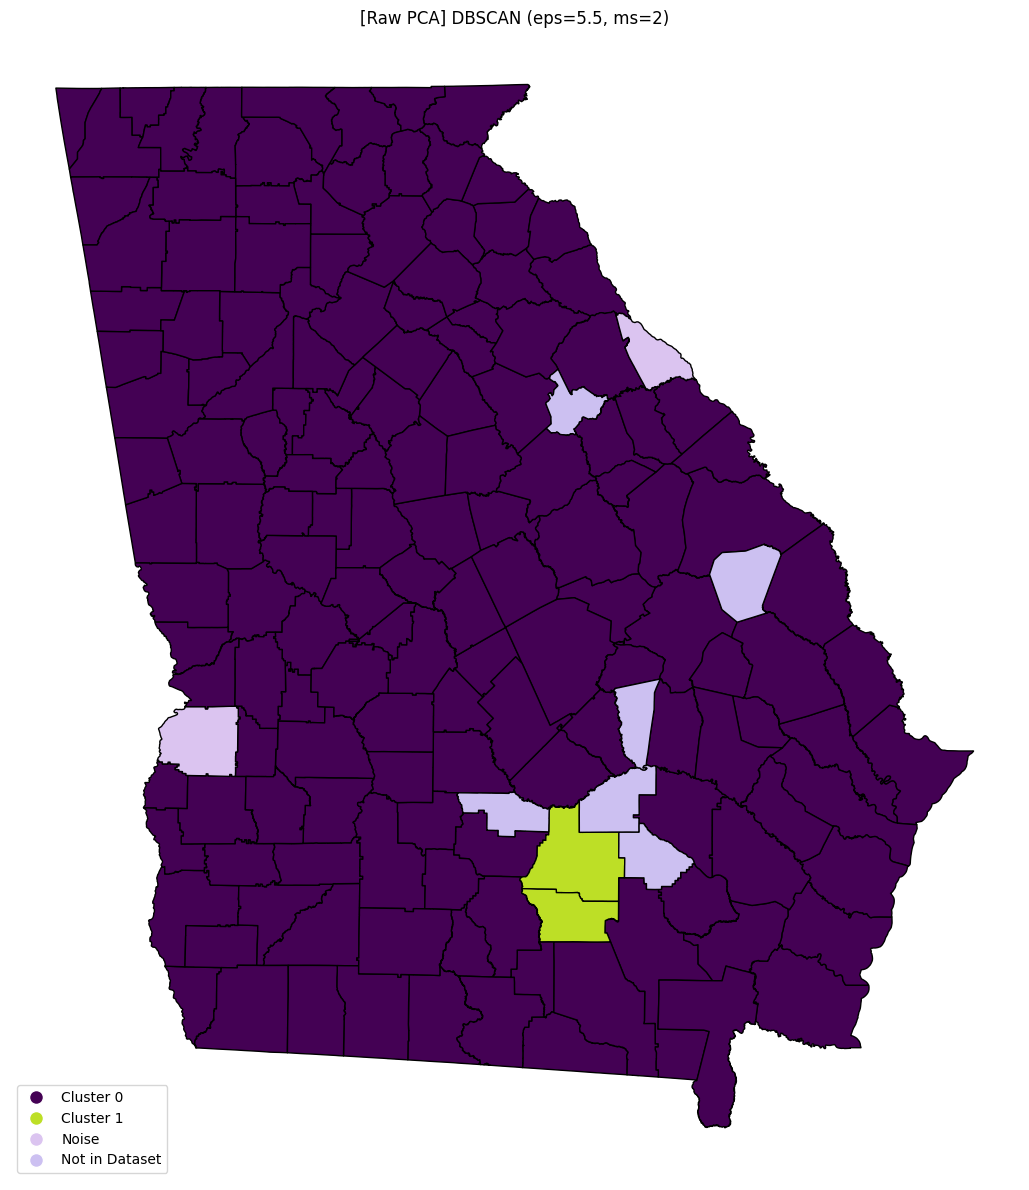

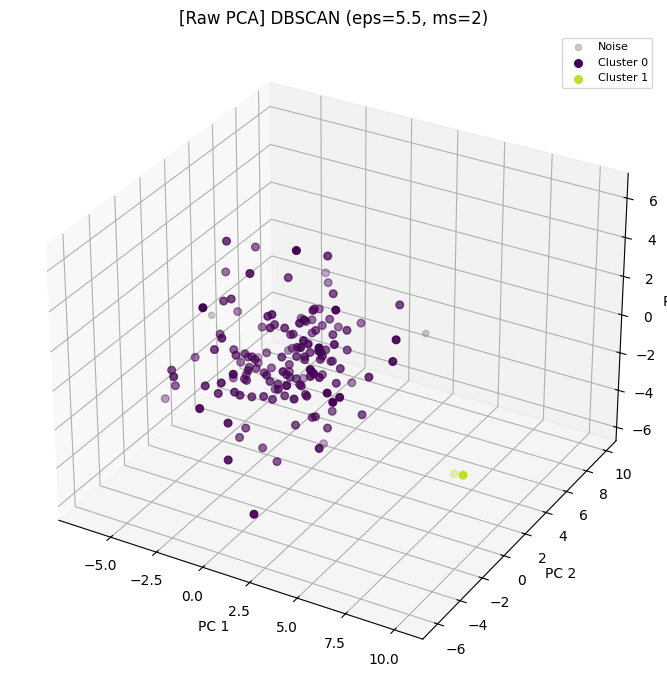


--- GCN Embedding Space ---


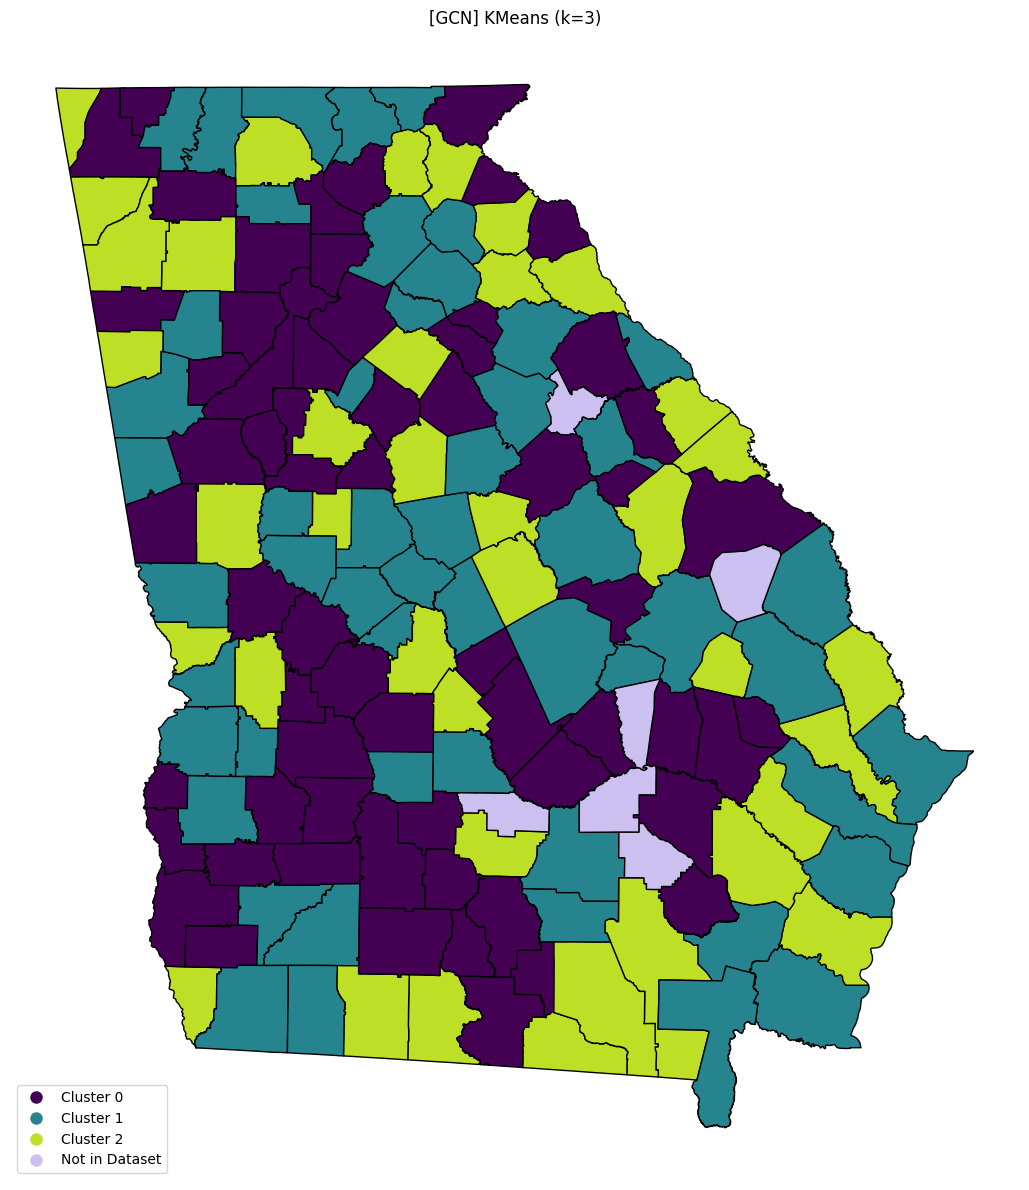

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


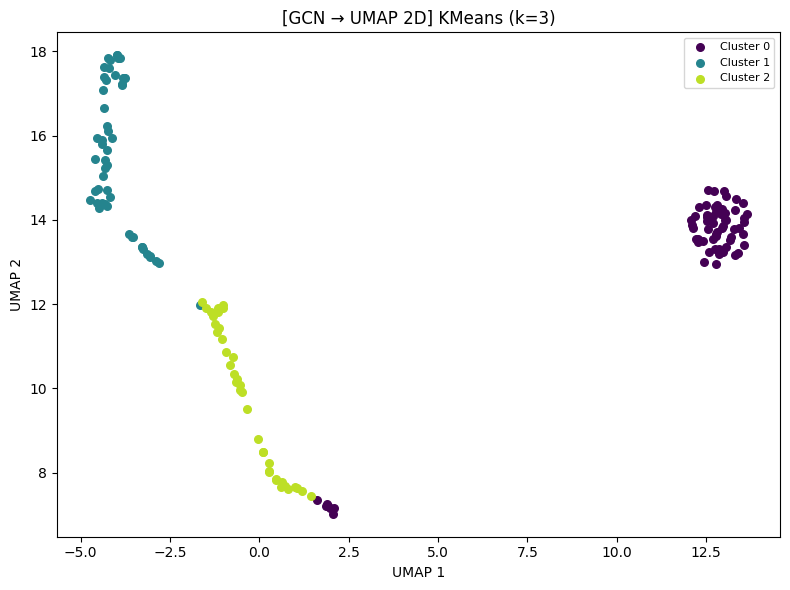

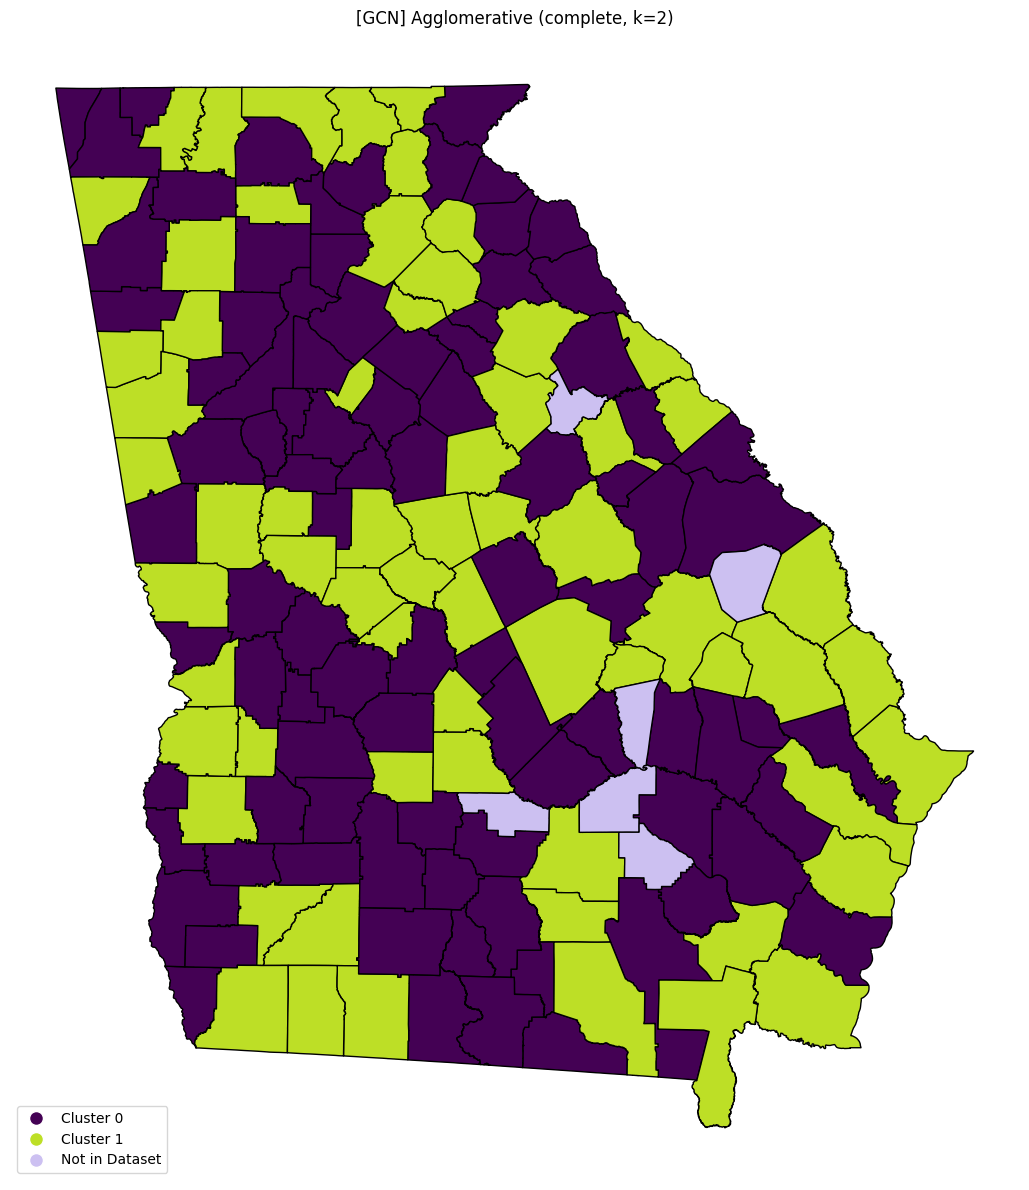

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


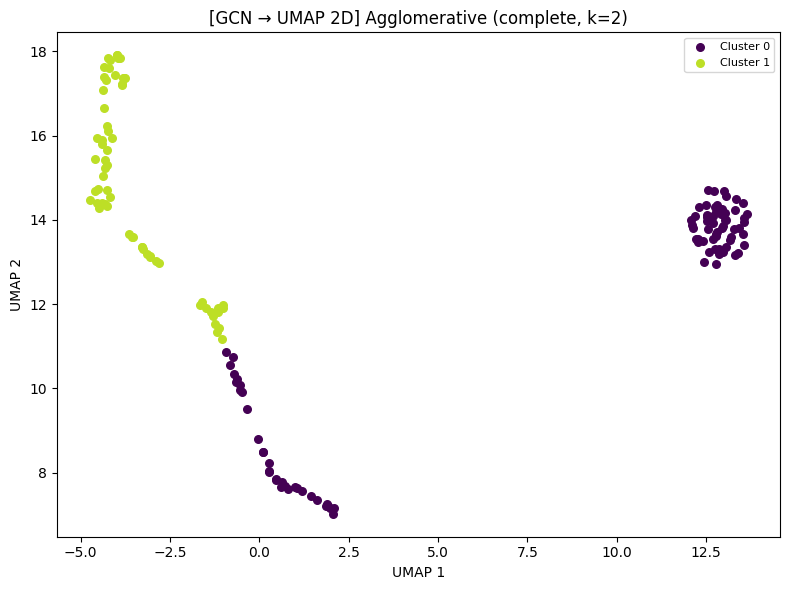

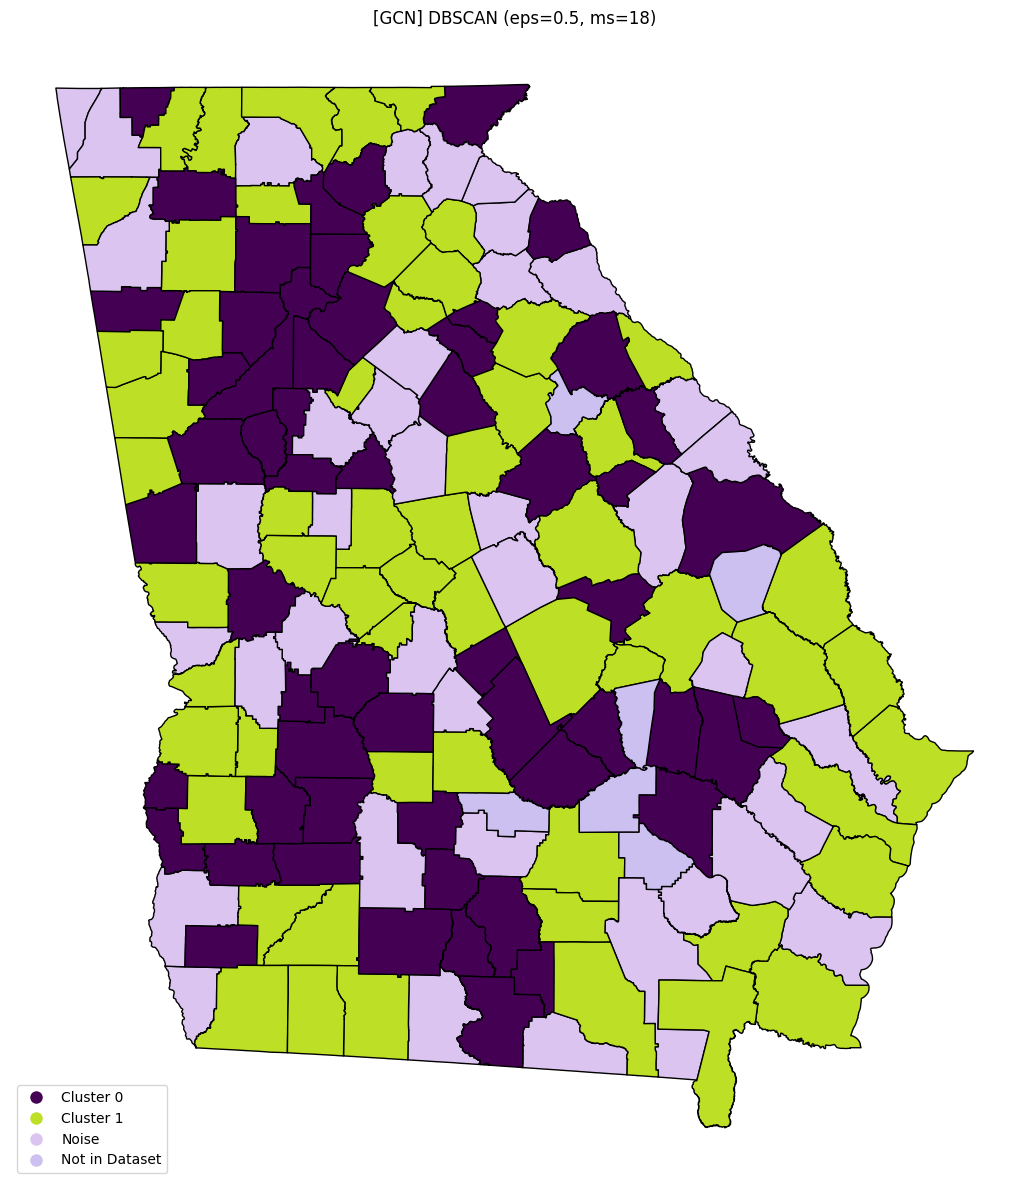

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


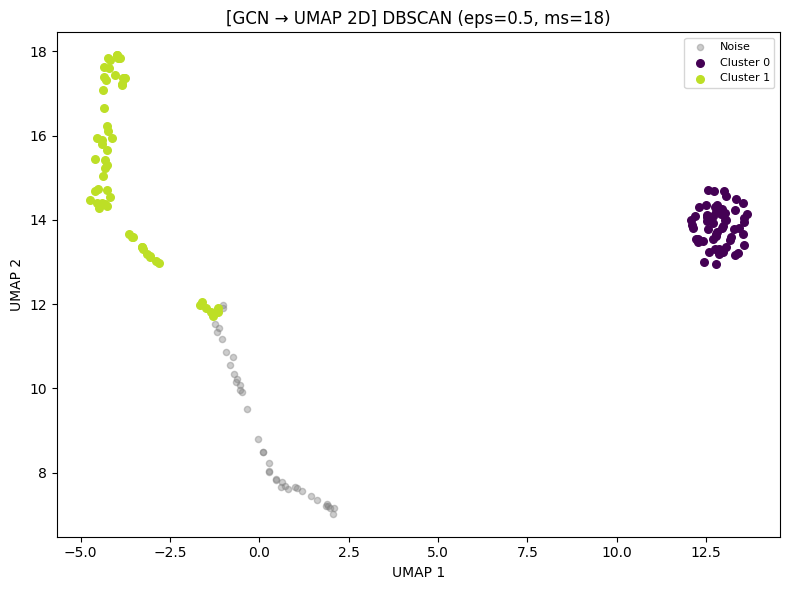

In [303]:
# ==========================================================================
# Comparison block: Raw PCA features vs GCN embeddings across clustering
# methods.  Produces a side-by-side table AND Georgia maps for all combos.
#
# Key design choices:
#   • KMeans & Agglomerative use the SAME k/linkage found by earlier cells
#     so the ONLY variable is the data representation (fair comparison).
#   • DBSCAN is grid-searched per space because eps doesn't transfer across
#     different dimensionalities (5-D PCA vs 64-D GCN).
# ==========================================================================

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Pull params from the individual cells (no hard-coding!) ---------------
# KMeans k came from Cell 11's grid search (select_best_kmeans)
COMP_KMEANS_K = kmeans_k                # set in Cell 11
# Agglomerative k & linkage came from Cell 18's grid search
COMP_AGG_K = agg_search["k"]            # set in Cell 18
COMP_AGG_LINKAGE = agg_search["linkage"]
# DBSCAN will be grid-searched below per space (eps is scale-dependent)
DBSCAN_EPS_VALUES = np.arange(0.5, 15, 0.5)
DBSCAN_MIN_SAMPLES_VALUES = range(2, 25)
DBSCAN_NOISE_CAP = 0.30

print(f"Comparison params: KMeans k={COMP_KMEANS_K}, "
      f"Agg linkage={COMP_AGG_LINKAGE} k={COMP_AGG_K}, "
      f"DBSCAN grid-searched per space (noise cap={DBSCAN_NOISE_CAP:.0%})")

# --- Build the two data spaces ---------------------------------------------
# FIX: drop 'Cluster' column if it was added by earlier cells (data leakage!)
feature_cols = [c for c in coefficients_df_cleaned.columns if c not in ('County', 'Cluster')]
X_raw = coefficients_df_cleaned[feature_cols].values
pca = PCA(n_components=PCA_COMPONENTS)
X_raw_pca = pca.fit_transform(X_raw)

X_gcn = embeddings4  # latent embeddings from Cell 22
county_names = coefficients_df_cleaned['County'].values


# --- Metrics helper --------------------------------------------------------
def compute_metrics(X, labels, noise_label=None):
    labels = np.asarray(labels)
    total = len(labels)
    noise_mask = (labels == noise_label) if noise_label is not None else np.zeros(total, dtype=bool)
    n_noise = int(noise_mask.sum())
    used_mask = ~noise_mask
    unique_labels = np.unique(labels[used_mask]) if used_mask.any() else []

    if used_mask.any():
        ids, counts = np.unique(labels[used_mask], return_counts=True)
        size_map = dict(zip(ids.tolist(), counts.tolist()))
    else:
        size_map = {}

    if X is not None and len(unique_labels) >= 2:
        X_eval = X[used_mask] if noise_label is not None else X
        l_eval = labels[used_mask] if noise_label is not None else labels
        sil = silhouette_score(X_eval, l_eval)
        dbi = davies_bouldin_score(X_eval, l_eval)
        chi = calinski_harabasz_score(X_eval, l_eval)
    else:
        sil, dbi, chi = None, None, None

    return {
        "n_total": total, "n_clusters": len(unique_labels),
        "noise_pct": (n_noise / total) if noise_label is not None else 0.0,
        "cluster_sizes": size_map,
        "silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": chi,
    }


# --- Run all 3 methods on a given data space -------------------------------
def run_all_methods(X, space_label):
    results = []
    label_dict = {}  # store labels for maps

    # KMeans (k from Cell 11 grid search)
    km_labels = KMeans(n_clusters=COMP_KMEANS_K, random_state=42).fit_predict(X)
    m = compute_metrics(X, km_labels)
    method_tag = f"KMeans (k={COMP_KMEANS_K})"
    results.append({"space": space_label, "method": method_tag, **m})
    label_dict[method_tag] = km_labels

    # Agglomerative (k & linkage from Cell 18 grid search)
    agg_labels = AgglomerativeClustering(
        n_clusters=COMP_AGG_K, linkage=COMP_AGG_LINKAGE
    ).fit_predict(X)
    m = compute_metrics(X, agg_labels)
    method_tag = f"Agglomerative ({COMP_AGG_LINKAGE}, k={COMP_AGG_K})"
    results.append({"space": space_label, "method": method_tag, **m})
    label_dict[method_tag] = agg_labels

    # DBSCAN - grid-search eps & min_samples for THIS space
    db_search = select_best_dbscan(
        X, eps_values=DBSCAN_EPS_VALUES,
        min_samples_values=DBSCAN_MIN_SAMPLES_VALUES,
        noise_cap=DBSCAN_NOISE_CAP,
    )
    if db_search["eps"] is not None:
        db_labels = DBSCAN(eps=db_search["eps"], min_samples=db_search["min_samples"]).fit_predict(X)
        m = compute_metrics(X, db_labels, noise_label=-1)
        method_tag = f"DBSCAN (eps={db_search['eps']:.1f}, ms={db_search['min_samples']})"
    else:
        db_labels = np.full(len(X), -1)
        m = compute_metrics(X, db_labels, noise_label=-1)
        method_tag = "DBSCAN (no valid params)"
    results.append({"space": space_label, "method": method_tag, **m})
    label_dict[method_tag] = db_labels

    return results, label_dict


# --- Execute ---------------------------------------------------------------
pca_results, pca_labels = run_all_methods(X_raw_pca, f"Raw PCA ({PCA_COMPONENTS}D)")
gcn_results, gcn_labels = run_all_methods(X_gcn, "GCN embeddings (64-D latent)")

comparison_df = pd.DataFrame(pca_results + gcn_results)

print("\n=== Clustering Comparison Summary ===")
display_cols = ["space", "method", "n_clusters", "noise_pct",
                "silhouette", "davies_bouldin", "calinski_harabasz", "cluster_sizes"]
print(comparison_df[display_cols].to_string(index=False))

print("\nNotes:")
print("- KMeans & Agglomerative use the same k/linkage in both spaces for a fair comparison.")
print("- DBSCAN eps is grid-searched per space (eps doesn\'t transfer across dimensionalities).")
print("- Silhouette/DBI/CH computed on non-noise points for DBSCAN.")
print("- GCN metrics are in 64-D latent space; PCA metrics are in 5-D PCA space.")

# --- Scatter-plot helper ---------------------------------------------------
# For PCA (5-D) we plot the first 3 components directly (they hold the most
# variance).  For GCN (64-D) we project into 2-D with UMAP so the clusters
# are actually visible — plotting raw dims 0-2 of a 64-D space is not useful.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap as umap_lib  # alias to avoid name clash with earlier cells

def plot_cluster_scatter(X, labels, title, noise_label=None, use_umap_2d=False):
    """3-D scatter (PCA) or 2-D UMAP scatter (GCN) colored by cluster."""
    labels = np.asarray(labels)
    unique = sorted(set(labels))
    n_real = len([u for u in unique if u != noise_label])
    colors = plt.cm.viridis(np.linspace(0, 0.9, max(n_real, 1)))

    if use_umap_2d:
        # 2-D UMAP projection — best way to visualise high-D embeddings
        proj = umap_lib.UMAP(n_components=2, random_state=42).fit_transform(X)
        fig, ax = plt.subplots(figsize=(8, 6))
        color_idx = 0
        for u in unique:
            mask = labels == u
            if u == noise_label:
                ax.scatter(proj[mask, 0], proj[mask, 1],
                           c='gray', alpha=0.4, s=20, label='Noise')
            else:
                ax.scatter(proj[mask, 0], proj[mask, 1],
                           c=[colors[color_idx]], s=30, label=f'Cluster {u}')
                color_idx += 1
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title(title)
        ax.legend(loc='best', fontsize=8)
        plt.tight_layout()
        plt.show()
    else:
        # 3-D scatter using first 3 dims (ideal for PCA where dim order = variance)
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        color_idx = 0
        for u in unique:
            mask = labels == u
            if u == noise_label:
                ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                           c='gray', alpha=0.4, s=20, label='Noise')
            else:
                ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                           c=[colors[color_idx]], s=30, label=f'Cluster {u}')
                color_idx += 1
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        ax.set_title(title)
        ax.legend(loc='best', fontsize=8)
        plt.tight_layout()
        plt.show()


# --- Georgia maps + scatter plots for all 6 combos -------------------------
print("\n--- Raw PCA Space ---")
for method_tag, labels in pca_labels.items():
    noise_lbl = -1 if "DBSCAN" in method_tag else None
    # Georgia shapefile map
    plot_ga_cluster_map(labels, county_names,
                        title=f"[Raw PCA] {method_tag}", noise_label=noise_lbl)
    # 3-D PCA scatter (first 3 components)
    plot_cluster_scatter(X_raw_pca, labels,
                         title=f"[Raw PCA] {method_tag}",
                         noise_label=noise_lbl, use_umap_2d=False)

print("\n--- GCN Embedding Space ---")
for method_tag, labels in gcn_labels.items():
    noise_lbl = -1 if "DBSCAN" in method_tag else None
    # Georgia shapefile map
    plot_ga_cluster_map(labels, county_names,
                        title=f"[GCN] {method_tag}", noise_label=noise_lbl)
    # 2-D UMAP scatter (projects 64-D embeddings into a viewable 2-D plane)
    plot_cluster_scatter(X_gcn, labels,
                         title=f"[GCN → UMAP 2D] {method_tag}",
                         noise_label=noise_lbl, use_umap_2d=True)
